# Data preprocessing
- this notebook shows the development of the entire data preprocessing pipeline to prepare the data for ML

In [42]:
import importlib
import all_funcs
importlib.reload(all_funcs)
from all_funcs import *

### Baseline
- baseline correction is developed and tested on multiple event types

Moving average

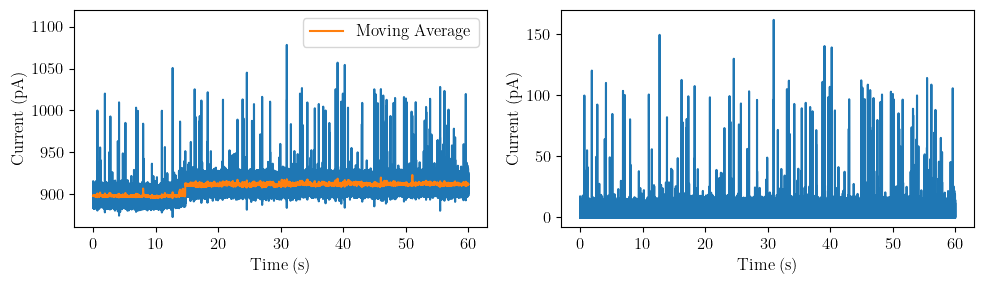

In [11]:
path = "/Users/joehart/Desktop/chemistry/Year 4/MSci project/MATLAB/Nanoparticledata_oct/Ctest_20Seeds9_0005.abf"

x_nores, y_nores, sma_nores, y_corrected_nores, y_base_nores, x_base_nores = importABF_movingavg(path, resistive = False)

plot_baseline_correct(x_nores, y_nores, sma_nores, y_corrected_nores, y_base_nores, x_base_nores)#, filename='baseline_corrected_nores')

Above and below baseline

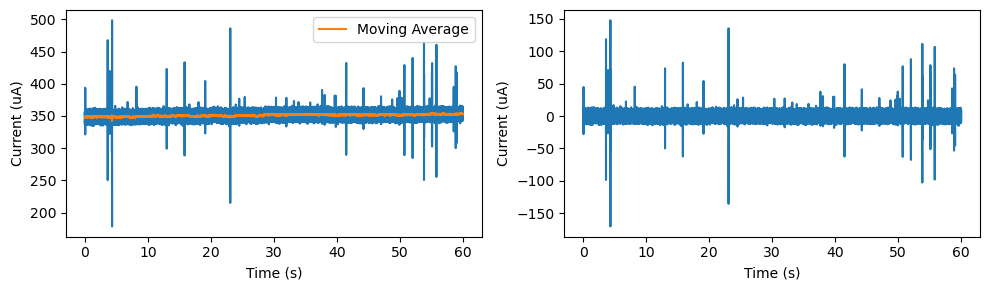

In [7]:
path = "/Users/joehart/Desktop/chemistry/Year 4/MSci project/MATLAB/10_nm_AuNP_SDS_in_50_mM_KCl_with_PEG_35k_bath/p18_4_50mM_KCl_10nmAunP_SDS_i2o_PEG35k_0002.abf"

x_NP, y_NP, sma_NP, y_corrected_NP, y_base_NP, x_base_NP = importABF_movingavg(path, resistive = True)    

plot_baseline_correct_resistive(x_NP, y_NP, sma_NP, y_base_NP, x_base_NP)

/Users/joehart/Desktop/chemistry/Year 4/MSci project/Python_nanopores/code_nanopores/all_funcs.py:172: UserWarning: The figure layout has changed to tight
  #plt.title('Baseline Corrected')
/Users/joehart/Desktop/chemistry/Year 4/MSci project/Python_nanopores/code_nanopores/all_funcs.py:176: UserWarning: The figure layout has changed to tight
  if filename:


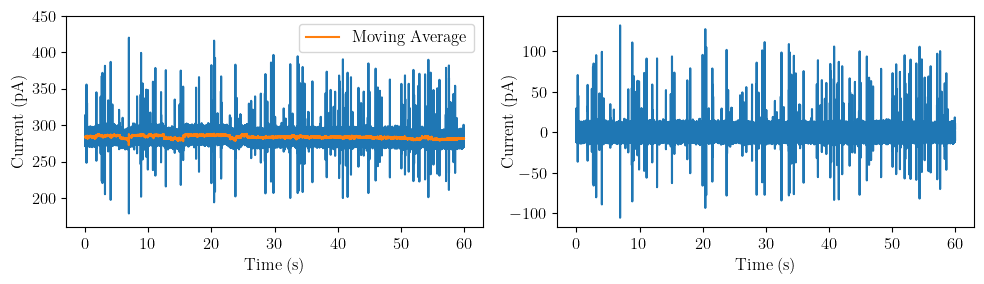

In [43]:
path = "/Users/joehart/Desktop/chemistry/Year 4/MSci project/MATLAB/5_nm_AuNP_SDS_in_50_mM_KCl_PEG_35k_bath/p18_31_50mM_KCl_5nmAunP_SDS_i2o_PEG35k_500mV_0002.abf"

x_5nm_0002, y_5nm_0002, sma_5nm_0002, y_corrected_5nm_0002, y_base_5nm_0002, x_base_5nm_0002 = importABF_movingavg(path, resistive = True)    

plot_baseline_correct_resistive(x_5nm_0002, y_5nm_0002, sma_5nm_0002, y_base_5nm_0002, x_base_5nm_0002, filename='baseline_corrected_resistive')

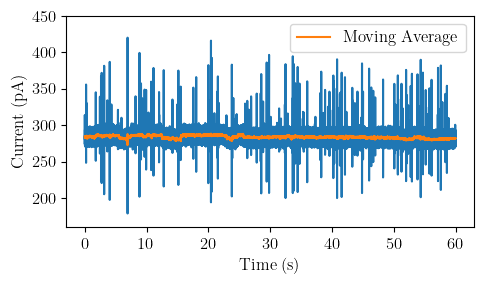

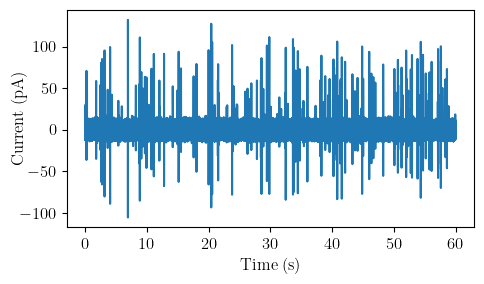

In [41]:
plt.figure(figsize=(5, 3)) 
plt.plot(x_5nm_0002, y_5nm_0002)
plt.plot(x_5nm_0002, sma_5nm_0002, label='Moving Average', linestyle='-')
plt.xlabel('Time (s)')
plt.ylabel('Current (pA)')
plt.ylim(160, 450)
#plt.title('Raw Data')
plt.legend(loc = "upper right")
plt.tight_layout()

plt.figure(figsize=(5, 3)) 
plt.plot(x_base_5nm_0002, y_base_5nm_0002)
plt.xlabel('Time (s)')
plt.ylabel('Current (pA)', labelpad = -5)
plt.tight_layout()

### Threshold

Threshold: no. events << total no. datapoints -> can just sd the whole run

In [6]:
def define_threshold(y_base, n_sd):
    sd_noise = np.std(y_base)
    mean_noise = np.mean(y_base)
    threshold = mean_noise + n_sd * sd_noise
    return threshold, mean_noise, sd_noise

In [12]:
threshold, mean_noise, sd_noise = define_threshold(y_base_nores, 15)
threshold, mean_noise, sd_noise

(46.27897347901174, 1.6521113285665032, 2.975124143363016)

In [13]:
# resistive peaks
threshold_NP, mean_noise_NP, sd_noise_NP = define_threshold(y_base_NP, 10)
threshold_NP, mean_noise_NP, sd_noise_NP

(30.139263329509316, -0.0008275336159871382, 3.01400908631253)

In [7]:
# 5nm_0002
threshold_5nm_0002, mean_noise_5nm_0002, sd_noise_5nm_0002 = define_threshold(y_base_5nm_0002, 10)
threshold_5nm_0002, mean_noise_5nm_0002, sd_noise_5nm_0002

(35.720705370322925, 0.0003705294763361311, 3.5720334840846593)

#### Threshold plots

(0.0, 50.0)

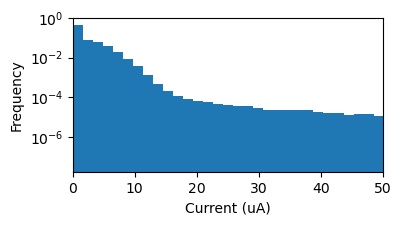

In [18]:
plt.hist(y_base, bins = 100, density=True) # PDF so area under curve = 1
plt.yscale('log')
plt.ylabel('Frequency')
plt.xlabel('Current (uA)')
plt.yticks([10**-6, 10**-4, 10**-2, 10**0])
plt.xlim(0, 50)

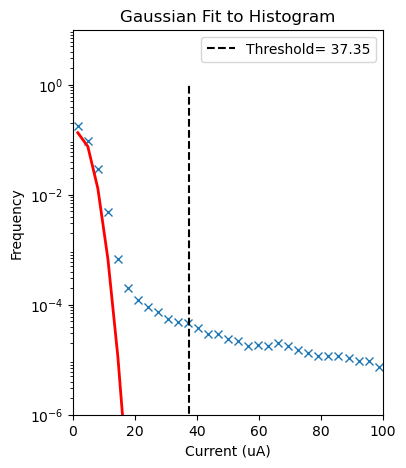

In [653]:
# gaussian first
from scipy.stats import norm

# Assuming y_base is your data

threshold = mean_noise + 12*sd_noise

# Create histogram
hist_values, bin_edges = np.histogram(y_base[y_base>0], bins=50, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Gaussian fit
mu, sigma = mean_noise, sd_noise
gaussian_pdf = norm.pdf(bin_centers, mu, sigma)

plt.figure(figsize=(4, 5))

# Plot histogram
plt.plot(bin_centers, hist_values, linestyle="", marker='x')

# Plot Gaussian fit
plt.plot(bin_centers, gaussian_pdf, 'red', linewidth=2)
plt.vlines(threshold, 0, 1, color='k', linestyle='--', label='Threshold= %.2f' % threshold)

# Additional plot settings (customize as needed)
plt.yscale('log')
plt.ylabel('Frequency')
plt.xlabel('Current (uA)')
plt.yticks([10**-6, 10**-4, 10**-2, 10**0])
plt.xlim(0,100)
plt.ylim(10**-6, 10**1)
plt.legend()
plt.title('Gaussian Fit to Histogram')

plt.show()


### Peak finder and event isolation

Peak finder

/var/folders/br/67qx_45113s31sykxddgpjyw0000gn/T/ipykernel_80561/2210897474.py:15: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


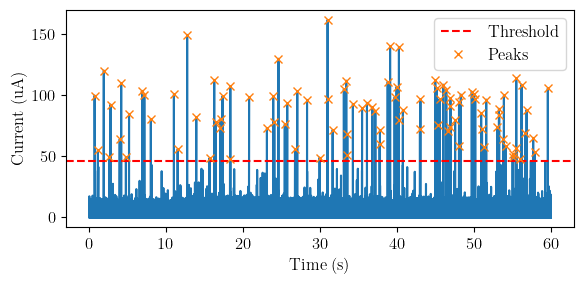

In [14]:
sd_threshold = mean_noise + 15*sd_noise

peaks_nores, properties_nores = find_peaks(y_base_nores, height=sd_threshold, distance=400, width = 50) # min 5000 data points between each peak, 5000 data points = 0.004s
# don't want to count a peak twice but don't want to miss if 2 peaks are nearby
# want to make distance equal to the average dwell time
plt.figure(figsize=(6, 3))
plt.plot(x_base_nores, y_base_nores)
plt.axhline(y=sd_threshold, color='r', linestyle='--', label='Threshold')
plt.plot(x_base_nores[peaks_nores], y_base_nores[peaks_nores], "x", label='Peaks')
plt.xlabel('Time (s)')
plt.ylabel('Current (uA)')
#plt.title('Peak Detection')
plt.tight_layout()
plt.legend(loc = 'upper right')
plt.tight_layout()
#plt.savefig('MSci_python_images/peak_finder_noresistive.png', dpi=300)
plt.show()


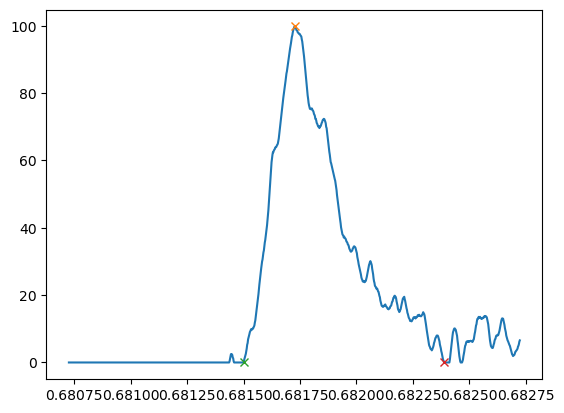

In [178]:
# rel_height = 1: left and right ips
peaks_nores, properties_nores = find_peaks(y_base_nores, height=sd_threshold, distance=400, width = 50, rel_height=1)
widths = properties_nores['widths']
left_peak = int(properties_nores['left_ips'][0])
right_peak = int(properties_nores['right_ips'][0])

plt.plot(x_base_nores[start_peak:end_peak], y_base_nores[start_peak:end_peak])
plt.plot(x_base_nores[peaks_nores[0]], y_base_nores[peaks_nores[0]], "x")
plt.plot(x_base_nores[left_peak], y_base_nores[left_peak], "x", label='Start')
plt.plot(x_base_nores[right_peak], y_base_nores[right_peak], "x", label='End')



In [193]:
filter_y_base_5nm_0002 = np.maximum(y_base_5nm_0002, 0)
peak_nores_widths = peak_widths(filter_y_base_5nm_0002, peaks_above_5nm_0002, rel_height=0.9)


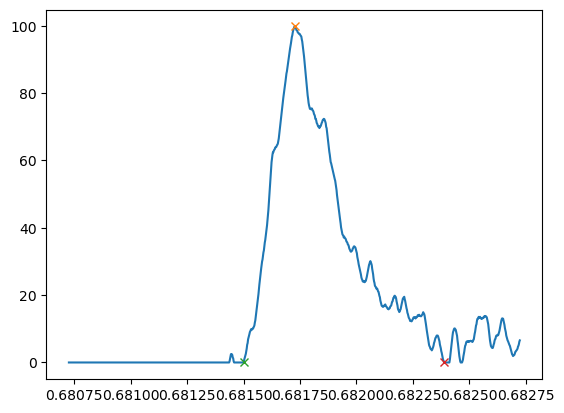

In [107]:
# rel_height = 1: peak width

peak_nores_widths = peak_widths(y_base_nores, peaks_nores, rel_height=1)
left_peak = int(peak_nores_widths[2][0])
right_peak = int(peak_nores_widths[3][0])
start_peak = int(peaks_nores[0] - 500)
end_peak = int(peaks_nores[0] + 500)
plt.plot(x_base_nores[start_peak:end_peak], y_base_nores[start_peak:end_peak])

plt.plot(x_base_nores[peaks_nores[0]], y_base_nores[peaks_nores[0]], "x", label='Peak')
plt.plot(x_base_nores[left_peak], y_base_nores[left_peak], "x", label='Start')
plt.plot(x_base_nores[right_peak], y_base_nores[right_peak], "x", label='End')

Resistive peaks: peak and trough finder

(37.3536010489227,
 None,
 array([  340863,   370272,   555907, ..., 28935856, 29618271, 29789309]),
 {'peak_heights': array([ 99.7961,  38.2778,  54.9924, ...,  53.5412,  45.3691, 105.7384]),
  'prominences': array([ 99.7961,  38.2778,  54.9924, ...,  53.5412,  45.3691, 105.7384]),
  'left_bases': array([  340750,   370225,   555635, ..., 28935616, 29618186, 29789138]),
  'right_bases': array([  341195,   370745,   556388, ..., 28936535, 29618715, 29790092]),
  'widths': array([149.6358, 140.077 , 250.5291, ..., 213.4781, 118.2948, 161.4135]),
  'width_heights': array([49.898 , 19.1389, 27.4962, ..., 26.7706, 22.6846, 52.8692]),
  'left_ips': array([  340807.2482,   370249.7697,   555720.8854, ..., 28935723.1208,
         29618231.0392, 29789235.8583]),
  'right_ips': array([  340956.8841,   370389.8467,   555971.4145, ..., 28935936.5989,
         29618349.334 , 29789397.2717])},
 None,
 None)

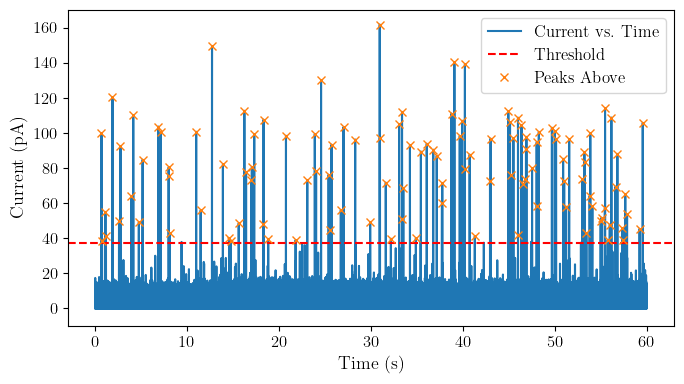

In [32]:
find_peaks_troughs(mean_noise, sd_noise, y_base_nores, x_base_nores, resistive = False, plot = True, savefilename = "peak_finder_noresistive")

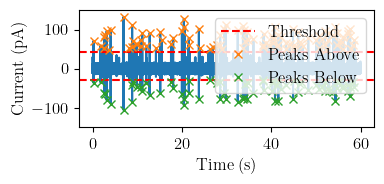

In [8]:
sd_threshold_5nm_0002, sd_threshold_lower_5nm_0002, peaks_above_5nm_0002, properties_above_5nm_0002, peaks_below_5nm_0002, properties_below_5nm_0002 = find_peaks_troughs(mean_noise_5nm_0002, sd_noise_5nm_0002, y_base_5nm_0002, x_base_5nm_0002, resistive = True, plot = True)#, savefilename = 'peak_finder_resistive_5nm_0002')


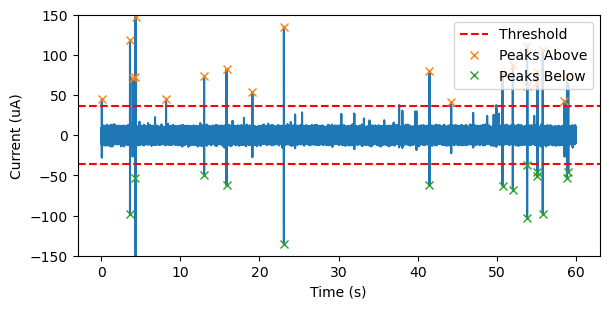

In [18]:
sd_threshold_NP, sd_threshold_lower_NP, peaks_above_NP, properties_above_NP, peaks_below_NP, properties_below_NP = find_peaks_troughs(mean_noise_NP, sd_noise_NP, y_base_NP, x_base_NP, resistive = True)


### Event isolation

In [15]:
event_time_nores, event_data_nores, event_data_smoothed_nores = event_isolation(x_base_nores, y_base_nores, peaks_nores, properties_nores)

In [24]:
event_time_NP, event_data_NP, smo_NP = event_isolation(x_base_NP, y_base_NP, peaks_above_NP, properties_above_NP, peaks_below_NP, properties_below_NP)

In [9]:
event_time_5nm_0002, event_data_5nm_0002, smo_5nm_0002 = event_isolation(x_base_5nm_0002, y_base_5nm_0002, peaks_above_5nm_0002, properties_above_5nm_0002, peaks_below_5nm_0002, properties_below_5nm_0002)

Data set with no resistive peaks

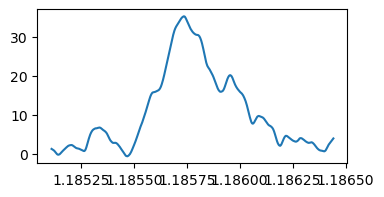

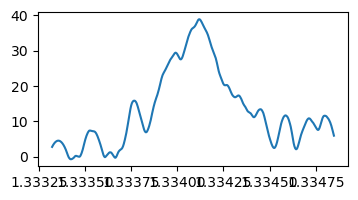

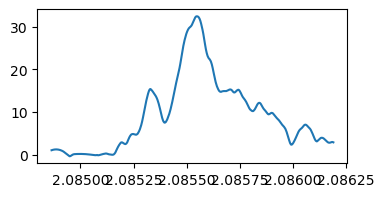

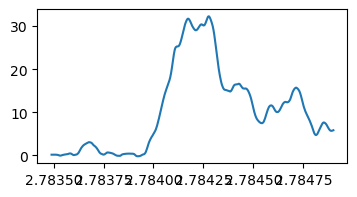

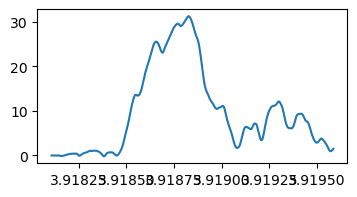

In [ ]:
for i in range(1):
    plt.plot(event_time_D[i], smo_D[i])
    #plt.ylim(-20,160)
    plt.show()

Data with resistive peaks

In [43]:
plt.rcParams['figure.figsize'] = [3,2]

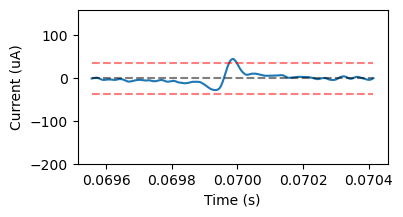

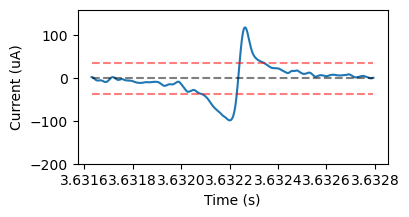

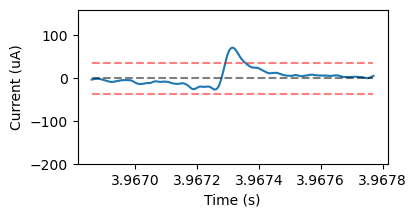

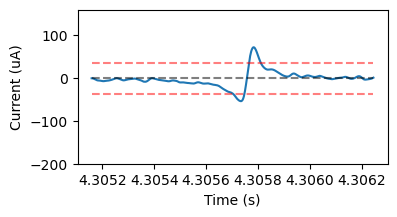

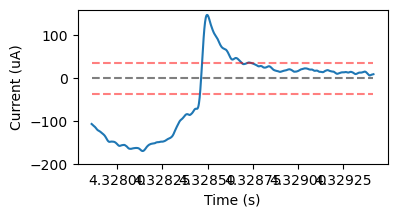

In [26]:
len(event_data_NP) # data with not many peaks and well defined
for i in range(5):
    plt.figure(figsize=(4,2))
    plt.plot(event_time_NP[i], event_data_NP[i])
    plt.hlines(mean_noise_NP, event_time_NP[i][0], event_time_NP[i][-1], color='k', linestyle='--', label='Baseline', alpha = 0.5)
    plt.hlines(sd_threshold_lower_NP, event_time_NP[i][0], event_time_NP[i][-1], color='r', linestyle='--', label='Threshold', alpha = 0.5)
    plt.hlines(sd_threshold_NP, event_time_NP[i][0], event_time_NP[i][-1], color='r', linestyle='--', label='Threshold', alpha = 0.5)

    plt.xlabel('Time (s)')
    plt.ylabel('Current (uA)')
    plt.ylim(-200,160)
    #plt.legend()
    plt.show()

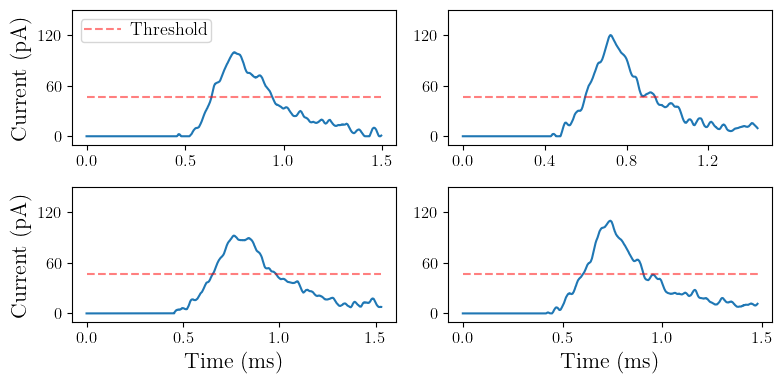

In [37]:


fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 4))
axes = axes.flatten() 

for idx, i in enumerate([0, 2, 4, 6]):
    t = np.linspace(0, len(event_data_nores[i]) * 2e-3, len(event_data_nores[i]))
    axes[idx].plot(t, event_data_nores[i])

    axes[idx].hlines(threshold, t[0], t[-1], color='r', linestyle='--', label='Threshold', alpha=0.5)

    if idx in [0, 2]:
        axes[idx].set_ylabel('Current (pA)', fontsize = 16)
    if idx in [2, 3]:
        axes[idx].set_xlabel('Time (ms)', fontsize = 16)

    axes[idx].set_ylim(-10, 150)
    #axes[idx].set_title(f'Event {i+1}')
    if idx == 0:
        axes[idx].legend(loc = 'upper left', fontsize = 13, borderaxespad=0.5, borderpad=0.2, handletextpad=0.5, labelspacing=0.2)
    # Set the x-axis to have a maximum of 4 ticks
    axes[idx].xaxis.set_major_locator(MaxNLocator(4))
    axes[idx].yaxis.set_major_locator(MaxNLocator(3))
    
plt.tight_layout()
#plt.savefig('/Users/joehart/Desktop/chemistry/Year 4/MSci project/Python_nanopores/MSci_python_images/event_isolation_nores.png', dpi=300)
plt.show()

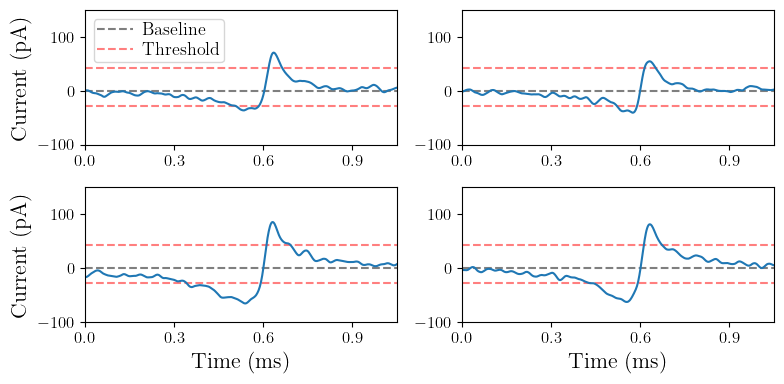

In [32]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 4))
axes = axes.flatten() 

for idx, i in enumerate([0, 10, 4, 3]):
    t = np.linspace(0, len(event_time_5nm_0002[i]) * 2e-3, len(event_time_5nm_0002[i]))
    axes[idx].hlines(mean_noise_5nm_0002, t[0], t[-1], color='k', linestyle='--', label='Baseline', alpha=0.5)
    axes[idx].hlines(sd_threshold_lower_5nm_0002, t[0], t[-1], color='r', linestyle='--', alpha=0.5)
    axes[idx].hlines(sd_threshold_5nm_0002, t[0], t[-1], color='r', linestyle='--', label='Threshold', alpha=0.5)
    axes[idx].plot(t, event_data_5nm_0002[i])
    axes[idx].set_xlim(0,1.05)

    if idx in [0, 2]:
        axes[idx].set_ylabel('Current (pA)', fontsize = 16)
    if idx in [2, 3]:
        axes[idx].set_xlabel('Time (ms)', fontsize = 16)

    axes[idx].set_ylim(-100, 150)
    #axes[idx].set_title(f'Event {i+1}')
    if idx == 0:
        axes[idx].legend(loc = 'upper left', fontsize = 13, borderaxespad=0.5, borderpad=0.2, handletextpad=0.5, labelspacing=0.2)
    # Set the x-axis to have a maximum of 4 ticks
    axes[idx].xaxis.set_major_locator(MaxNLocator(4))
    
plt.tight_layout()
#plt.savefig('/Users/joehart/Desktop/chemistry/Year 4/MSci project/Python_nanopores/MSci_python_images/event_isolation_5nm_0002.png', dpi=300)
plt.show()

Deciding on how to define peak start and end points
- peak width accurate for peaks
- peak width blows up for troughs
- for troughs use right_ips and left_ips to define peak width (will be smaller than actual peak width)

In [24]:

width_below_0NP = properties_below['widths'][0]

next_peakkk = find_next_peak(peaks_below[0], peaks_above)
width_above_0NP = properties_above['widths'][np.where(peaks_above == next_peakkk)[0][0]]

start_0NP = max(0, peaks_below[0] - width_below_0NP // 2) - 300
end_0NP = min(len(y_base_NP),next_peakkk + width_above_0NP // 2) +300
event_0NP = y_base_NP[int(start_0NP):int(end_0NP)]
time_0NP = x_base_NP[int(start_0NP):int(end_0NP)]


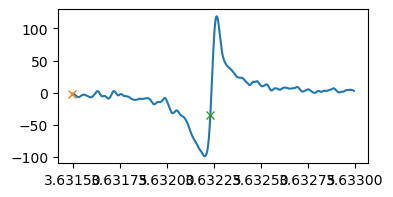

In [26]:
plt.plot(time_0NP, event_0NP)
plt.plot(x_base_NP[int(start_0NP)], y_base_NP[int(start_0NP)], "x", label='Peak')
plt.plot(x_base_NP[int(properties_below['right_ips'][0])], y_base_NP[int(properties_below['right_ips'][0])], "x", label='Left')

### Savitzky-Golay filter: smoothing
- conclusion: sub-optimal

In [51]:
plt.rcParams['figure.figsize'] = [4, 2]

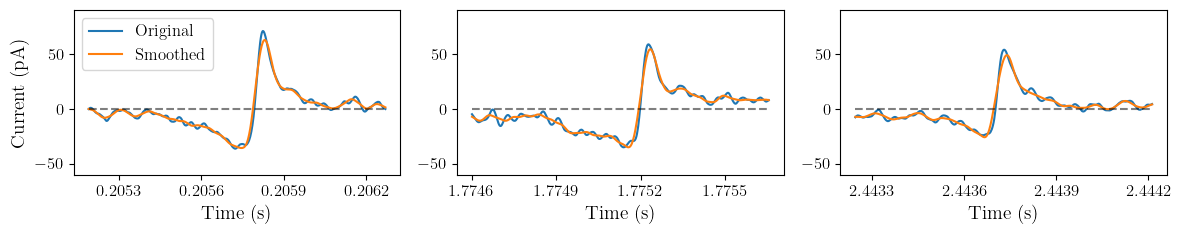

In [36]:
Psmot=[]
for i in range(len(event_data_5nm_0002)):  # sample selection
    vetor=event_data_5nm_0002[i]
    z=signal.savgol_filter(vetor, window_length=50, polyorder=3, mode="nearest")
    #z=signal.savgol_filter(vetor, window_length=30, polyorder=3, mode="nearest")

    Psmot.append(z)

fig, axes = plt.subplots(1, 3, figsize=(12, 2.5))

axes_flat = axes.flatten()  # Flatten the array for easier iteration

included_events = [0, 1, 2]


for idx, i in enumerate(included_events):
    ax = axes_flat[idx]
    ax.plot(event_time_5nm_0002[i], event_data_5nm_0002[i], label='Original')
    ax.plot(event_time_5nm_0002[i], Psmot[i], label='Smoothed')
    
    ax.set_ylabel('Current (pA)', fontsize = 14) if idx == 0 else None
    ax.set_xlabel('Time (s)', fontsize = 14)
    ax.legend(loc = "upper left") if idx == 0 else None 
    ax.hlines(0, event_time_5nm_0002[i][0], event_time_5nm_0002[i][-1], color='k', linestyle='--', alpha=0.5)

    ax.set_ylim(-60, 90)
    ax.xaxis.set_major_locator(MaxNLocator(4))

plt.tight_layout()
#plt.savefig("/Users/joehart/Desktop/chemistry/Year 4/MSci project/Python_nanopores/MSci_python_images/SG_filter.png", dpi=300)
plt.show()

## Loading -> event isolation 
- input is path, output is event_data + features

In [29]:
def load_to_event_data(path, resistive = False):
    x, y, sma, y_corrected, y_base, x_base = importABF_movingavg(path, resistive) 
    
    threshold, mean_noise, sd_noise = define_threshold(y_base, 12)
    
    sd_threshold, sd_threshold_lower, peaks_above, properties_above, peaks_below, properties_below = find_peaks_troughs(mean_noise, sd_noise, y_base, x_base, resistive)
    
    if resistive:
        event_time, event_data, smo = event_isolation(x_base, y_base, peaks_above, properties_above, peaks_below, properties_below)
        features_df, features_list = find_features(event_time, event_data, mean_noise, sd_threshold, sd_threshold_lower)
    else:
        event_time, event_data, smo = event_isolation(x_base, y_base, peaks_above, properties_above)
        features_df, features_list = find_features(event_time, event_data, mean_noise, sd_threshold, sd_threshold_lower)
        
    
    
    return event_time, event_data, smo, features_df, features_list, sd_threshold, sd_threshold_lower, mean_noise
    #return event_time, event_data, smo, sd_threshold, sd_threshold_lower, mean_noise


#### Auto loading

In [3]:
base_path = "/Users/joehart/Desktop/chemistry/Year 4/MSci project/MATLAB/5_nm_AuNP_SDS_in_50_mM_KCl_PEG_35k_bath/"
file_template = "p18_31_50mM_KCl_5nmAunP_SDS_i2o_PEG35k_500mV_{}.abf"

paths_5 = [base_path + file_template.format(str(i).zfill(4)) for i in range(2, 8)]

base_path = "/Users/joehart/Desktop/chemistry/Year 4/MSci project/MATLAB/10_nm_AuNP_SDS_in_50_mM_KCl_with_PEG_35k_bath/"
file_template = "p18_4_50mM_KCl_10nmAunP_SDS_i2o_PEG35k_{}.abf"

paths_10 = [base_path + file_template.format(str(i).zfill(4)) for i in range(2, 21)]

paths = paths_5 + paths_10

In [28]:
x_test, y_test, sma_test, y_corrected_test, y_base_test, x_base_test = importABF_movingavg(path, resistive= True) 

threshold_test, mean_noise_test, sd_noise_test = define_threshold(y_base_test, 12)



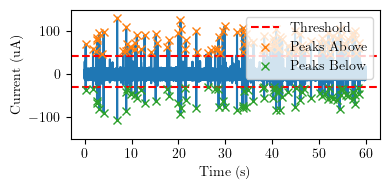

In [15]:
event_time_test2, event_data_test2, smo_test2, sd_threshold_test2, sd_threshold_lower_test2, mean_noise_test2 = load_to_event_data_nofeatures_NRNS(paths[0], resistive = True, small_resistive = True, plot = True)

In [78]:
data_1_to_20_df.to_pickle("data_1_to_20_df.pkl")

/var/folders/br/67qx_45113s31sykxddgpjyw0000gn/T/ipykernel_16459/883039534.py:33: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(6, 3))


event_time  \
run_1   [[0.205376, 0.20537799999999998, 0.20537999999...   
run_2   [[0.43807399999999996, 0.43807599999999997, 0....   
run_3   [[0.231812, 0.231814, 0.231816, 0.231818, 0.23...   
run_4   [[0.159718, 0.15972, 0.159722, 0.159724, 0.159...   
run_5   [[0.028617999999999998, 0.02862, 0.02862199999...   
run_6   [[0.20585599999999998, 0.20585799999999999, 0....   
run_7   [[0.06955599999999999, 0.069558, 0.06956, 0.06...   
run_8   [[2.70145, 2.7014519999999997, 2.701454, 2.701...   
run_9   [[1.37499, 1.374992, 1.3749939999999998, 1.374...   
run_10  [[2.973734, 2.9737359999999997, 2.973738, 2.97...   
run_11  [[0.9178759999999999, 0.917878, 0.917879999999...   
run_12  [[1.5749659999999999, 1.574968, 1.57497, 1.574...   
run_13  [[0.033642, 0.033644, 0.033645999999999995, 0....   
run_14  [[0.7534719999999999, 0.753474, 0.753475999999...   
run_15  [[0.877222, 0.877224, 0.877226, 0.877228, 0.87...   
run_16  [[0.066954, 0.066956, 0.066958, 0.066959999999...   
run_17  [[0.35021399999999997, 0.35021599999999997, 0....   
run_18  [[0.075542, 0.075544, 0.075546, 0.075547999999...   
run_19  [[0.112482, 0.112484, 0.11248599999999999, 0.1...   
run_20  [[0.222154, 0.222156, 0.222158, 0.22216, 0.222...   
run_21  [[0.549958, 0.54996, 0.549962, 0.549964, 0.549...   
run_22  [[0.337138, 0.33714, 0.337142, 0.337144, 0.337...   
run_23  [[0.42741399999999996, 0.42741599999999996, 0....   
run_24  [[0.049644, 0.049645999999999996, 0.049648, 0....   
run_25  [[0.009741999999999999, 0.009744, 0.009746, 0....   

                                               event_data  \
run_1   [[-7.510592707824571, -6.809045466613611, -5.9...   
run_2   [[-5.2560333374025845, -5.897885144043244, -6....   
run_3   [[-8.136563223266876, -8.260199087524711, -8.2...   
run_4   [[-1.934295654297216, -1.6901702880862217, -1....   
run_5   [[-2.5779053817750537, -2.4561097274781787, -2...   
run_6   [[-12.258566453552362, -12.045623948669572, -1...   
run_7   [[-0.6848602294913917, -0.44053955078049967, -...   
run_8   [[-3.7630859374992838, -4.31293334960867, -4.8...   
run_9   [[-7.261984252928755, -7.293136596678721, -7.2...   
run_10  [[-3.0311157226554997, -2.5429626464836588, -2...   
run_11  [[-6.158935546874034, -6.159713745116164, -6.2...   
run_12  [[-0.333084106444403, -0.4552276611319712, -0....   
run_13  [[-4.6333496093739654, -5.366427612303653, -6....   
run_14  [[-3.909463500976642, -3.7574035644532273, -3....   
run_15  [[-4.696478271484409, -4.269381713867233, -3.8...   
run_16  [[-2.0961273315429025, -2.0962188842772207, -2...   
run_17  [[2.2414947509764716, 2.1193939208983466, 1.90...   
run_18  [[-5.781219482420568, -5.5987518310533915, -5....   
run_19  [[-6.404403686522301, -5.245120239256664, -4.2...   
run_20  [[-6.81432495117042, -6.235806274412596, -5.59...   
run_21  [[-0.787771606444096, -0.7267578124987608, -0....   
run_22  [[-3.8713775634753915, -4.115869140623829, -4....   
run_23  [[1.3946716308607847, 1.394409179688921, 1.272...   
run_24  [[4.184622244264347, 4.032016043092483, 3.6657...   
run_25  [[1.6945130004902467, 1.0543030395527921, 0.41...   

                                                      smo  sd_threshold  \
run_1   [[-5.104433984282954, -4.95909533264184, -4.81...     42.864772   
run_2   [[-5.908120613921884, -5.802599818995471, -5.6...     43.042526   
run_3   [[-6.8956067845352615, -6.823236766577699, -6....     44.380590   
run_4   [[-0.11033804989149272, -0.06768006693112205, ...     44.056876   
run_5   [[-4.802860207214009, -4.953541729662973, -5.0...     43.355342   
run_6   [[-9.178884771473461, -8.846500802613537, -8.5...     43.976008   
run_7   [[-0.6261846308701708, -0.684363281519524, -0....     36.167282   
run_8   [[-5.190040745216837, -5.286091735970577, -5.3...     36.261649   
run_9   [[-6.048639242876117, -5.829595231128388, -5.6...     36.784230   
run_10  [[-2.687899952996251, -2.7510067953534265, -2....     37.329940   
run_11  [[-5.678644378847641, -5.494423369570481

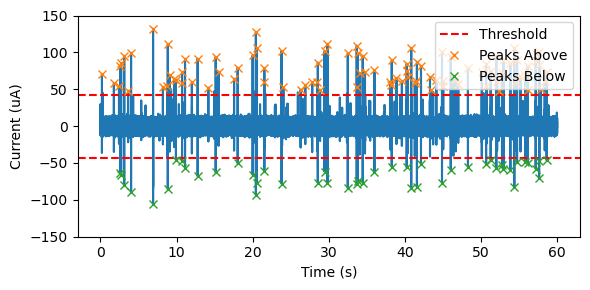

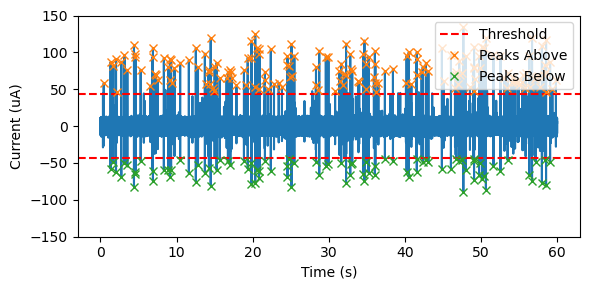

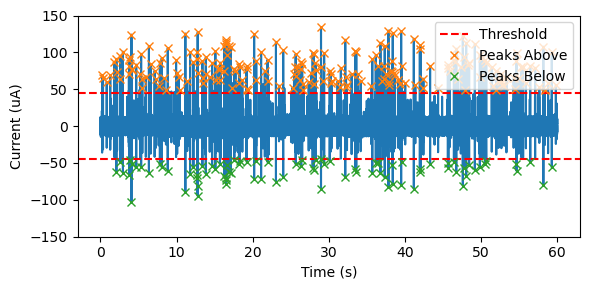

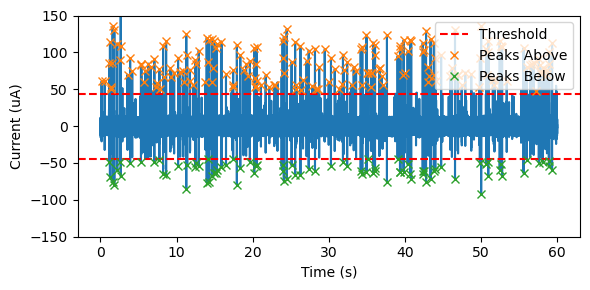

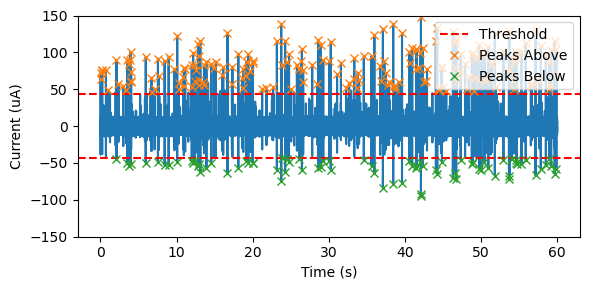

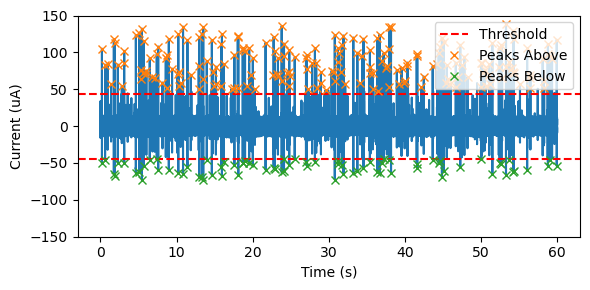

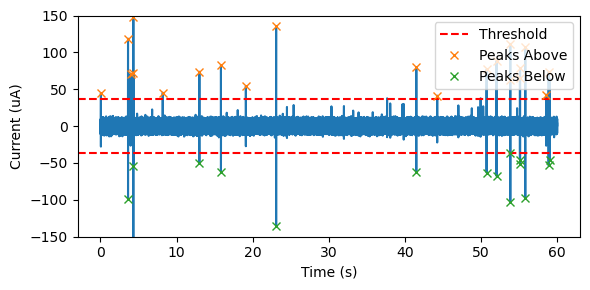

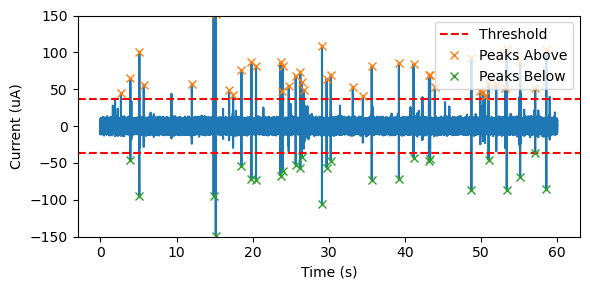

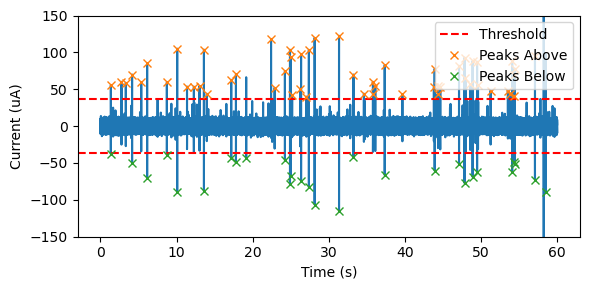

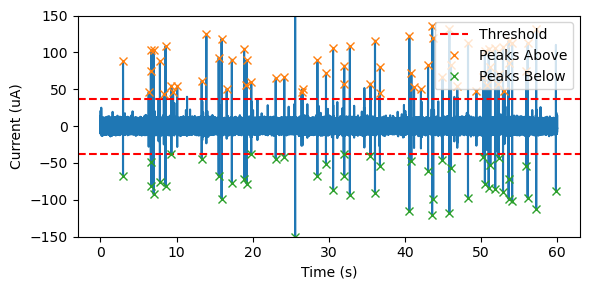

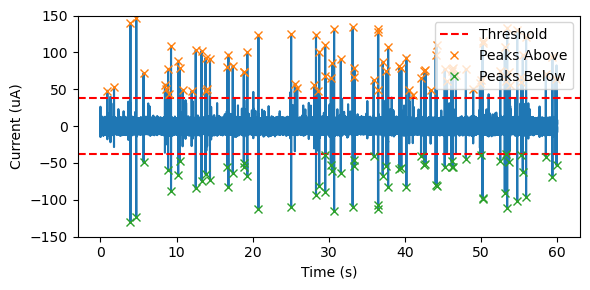

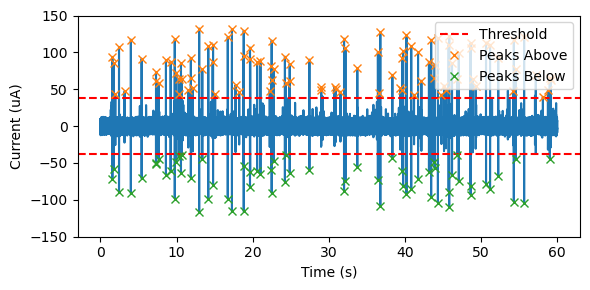

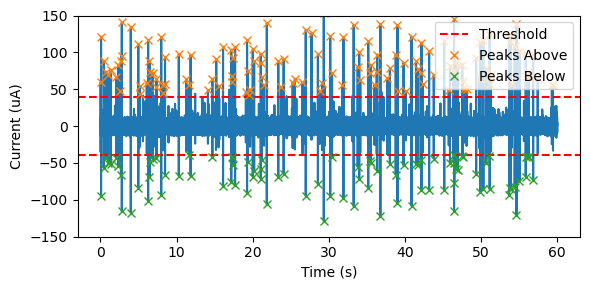

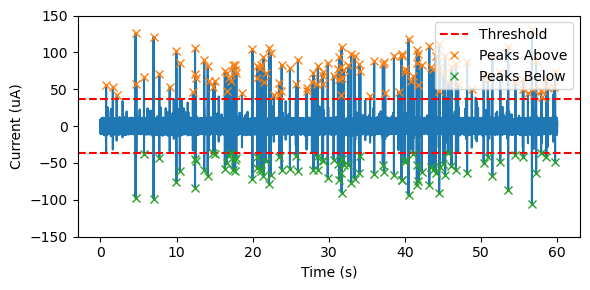

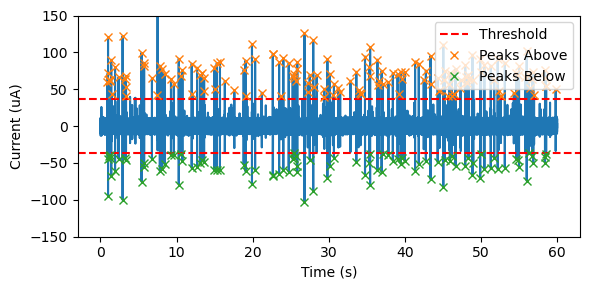

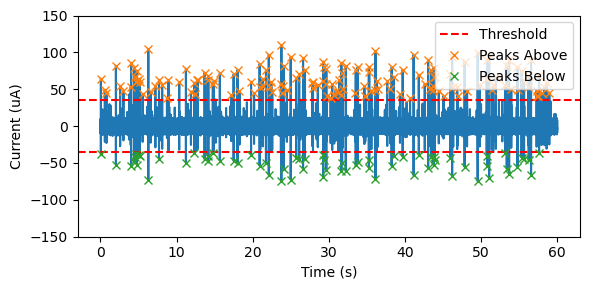

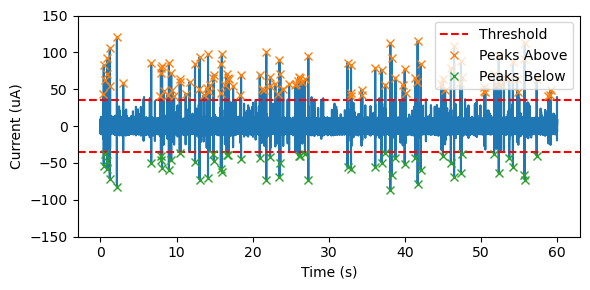

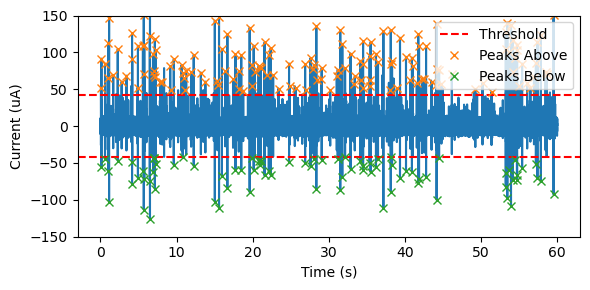

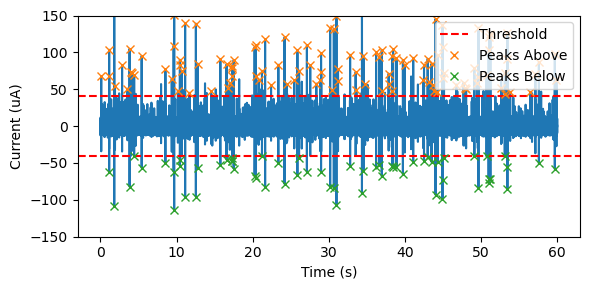

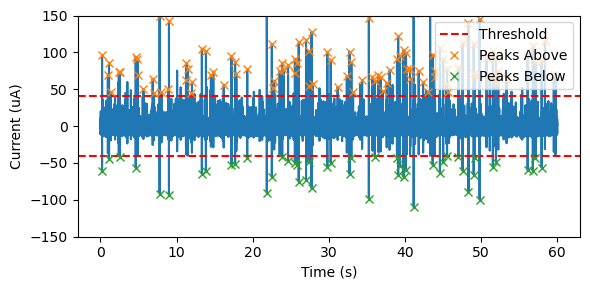

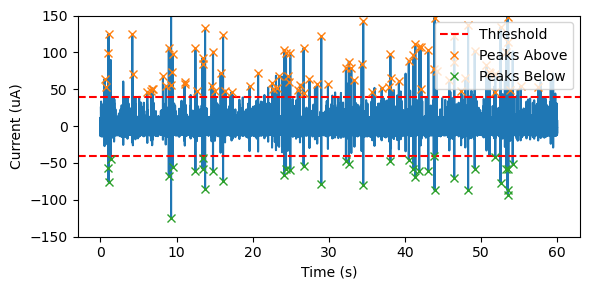

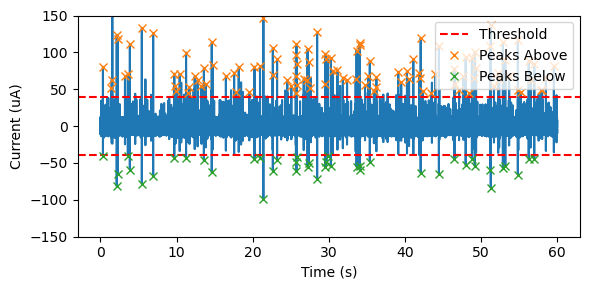

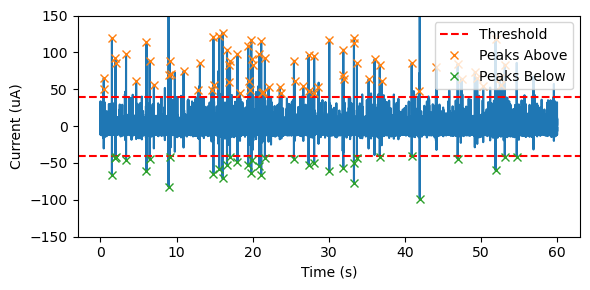

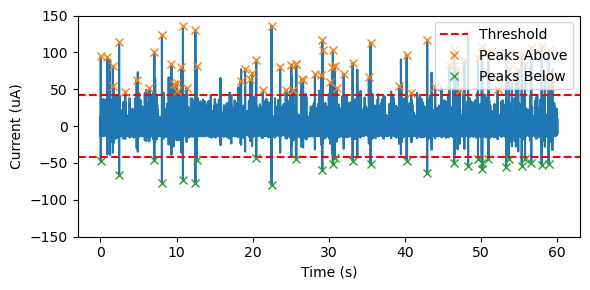

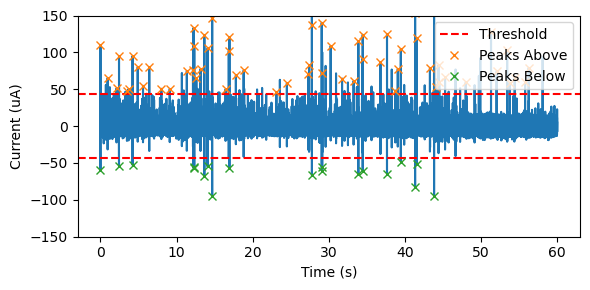

In [32]:
data_1_to_20_df = pd.DataFrame(columns = ["event_time", "event_data", "smo", "sd_threshold", "sd_threshold_lower", "mean_noise"])

for i in range(len(paths)):
    
    data = load_to_event_data_nofeatures(paths[i], resistive = True, plot = True)
    
    # each col should be event_time, event_data ...
    # each row is a different path
    
    data_1_to_20_df.loc[f"run_{i+1}"] = data
    
    
data_1_to_20_df

rerun event isolation and feature extraction

In [98]:
data_1_to_20_df2.to_pickle("data_1_to_20_df2.pkl")

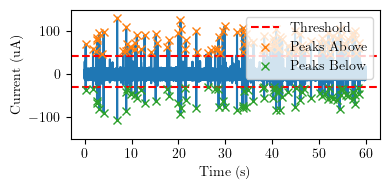

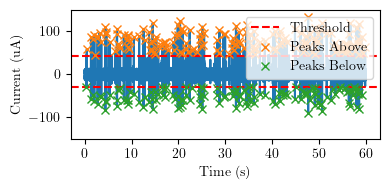

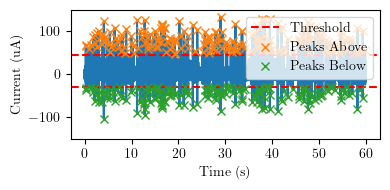

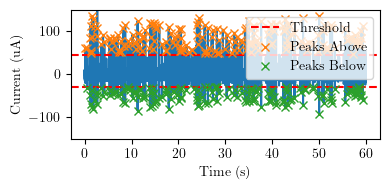

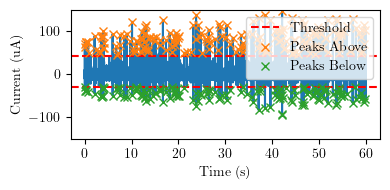

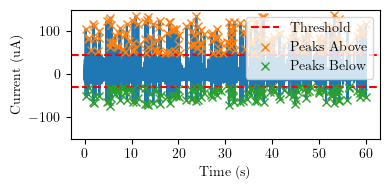

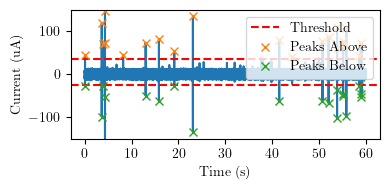

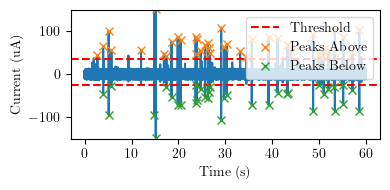

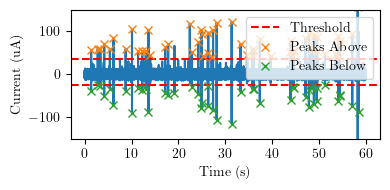

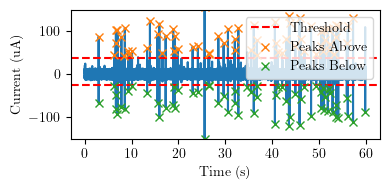

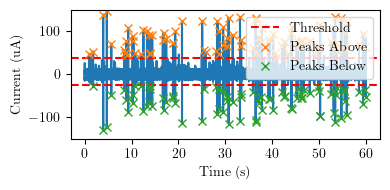

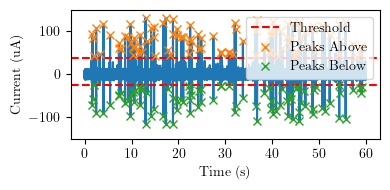

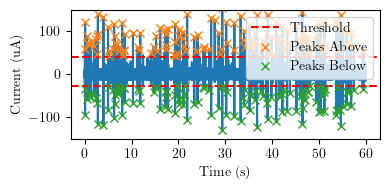

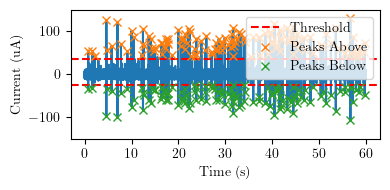

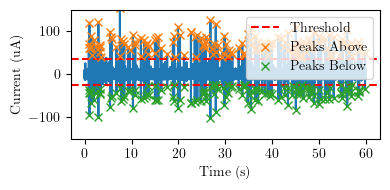

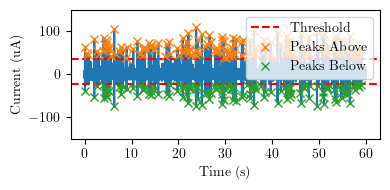

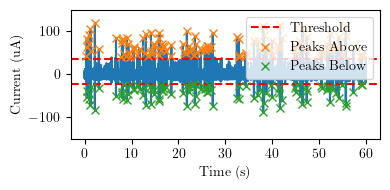

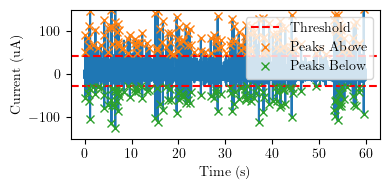

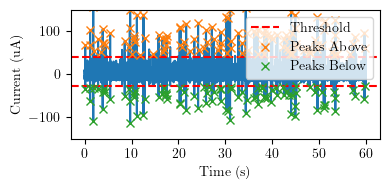

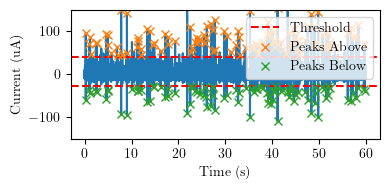

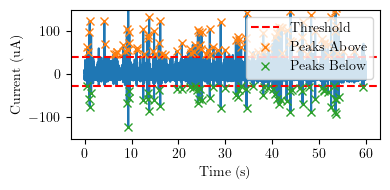

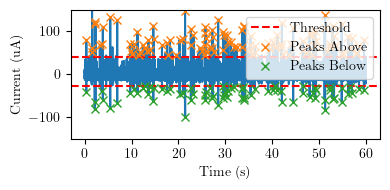

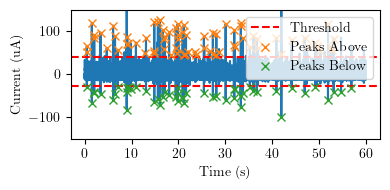

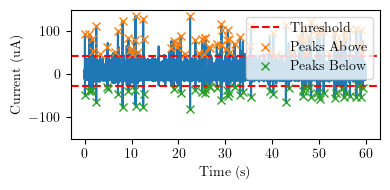

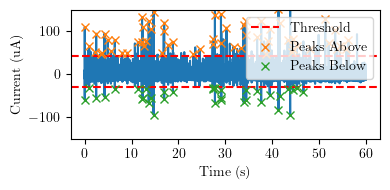

event_time  \
run_1   [[0.20518999999999998, 0.20519199999999999, 0....   
run_2   [[0.437532, 0.437534, 0.437536, 0.437538, 0.43...   
run_3   [[0.23163199999999998, 0.23163399999999998, 0....   
run_4   [[0.159718, 0.15972, 0.159722, 0.159724, 0.159...   
run_5   [[0.028426, 0.028428, 0.02843, 0.028432, 0.028...   
run_6   [[0.20585599999999998, 0.20585799999999999, 0....   
run_7   [[0.069354, 0.069356, 0.069358, 0.069359999999...   
run_8   [[2.70145, 2.7014519999999997, 2.701454, 2.701...   
run_9   [[1.37499, 1.374992, 1.3749939999999998, 1.374...   
run_10  [[2.973734, 2.9737359999999997, 2.973738, 2.97...   
run_11  [[0.9178759999999999, 0.917878, 0.917879999999...   
run_12  [[1.5749659999999999, 1.574968, 1.57497, 1.574...   
run_13  [[0.03345, 0.033451999999999996, 0.033454, 0.0...   
run_14  [[0.7533019999999999, 0.753304, 0.753305999999...   
run_15  [[0.87705, 0.8770519999999999, 0.877054, 0.877...   
run_16  [[0.066954, 0.066956, 0.066958, 0.066959999999...   
run_17  [[0.35021399999999997, 0.35021599999999997, 0....   
run_18  [[0.075542, 0.075544, 0.075546, 0.075547999999...   
run_19  [[0.112284, 0.112286, 0.112288, 0.11229, 0.112...   
run_20  [[0.222154, 0.222156, 0.222158, 0.22216, 0.222...   
run_21  [[0.54976, 0.549762, 0.549764, 0.549766, 0.549...   
run_22  [[0.337138, 0.33714, 0.337142, 0.337144, 0.337...   
run_23  [[0.42741399999999996, 0.42741599999999996, 0....   
run_24  [[0.049644, 0.049645999999999996, 0.049648, 0....   
run_25  [[0.009741999999999999, 0.009744, 0.009746, 0....   

                                               event_data  \
run_1   [[-0.27434392852768497, 0.1532653244020139, 0....   
run_2   [[-5.497137463379204, -5.863735974121369, -6.1...   
run_3   [[-1.845187490845035, -2.4865601715090975, -3....   
run_4   [[-1.934295654297216, -1.6901702880862217, -1....   
run_5   [[2.7516325820921566, 2.598846327209344, 2.293...   
run_6   [[-12.258566453552362, -12.045623948669572, -1...   
run_7   [[-2.7881042480461247, -3.001705932616403, -3....   
run_8   [[-3.7630859374992838, -4.31293334960867, -4.8...   
run_9   [[-7.261984252928755, -7.293136596678721, -7.2...   
run_10  [[-3.0311157226554997, -2.5429626464836588, -2...   
run_11  [[-6.158935546874034, -6.159713745116164, -6.2...   
run_12  [[-0.333084106444403, -0.4552276611319712, -0....   
run_13  [[1.77990722656358, 1.8105377197276766, 1.7495...   
run_14  [[-3.8401702880859716, -3.871072387695392, -3....   
run_15  [[-0.6915191650391534, -0.660833740234466, -0....   
run_16  [[-2.0961273315429025, -2.0962188842772207, -2...   
run_17  [[2.2414947509764716, 2.1193939208983466, 1.90...   
run_18  [[-5.781219482420568, -5.5987518310533915, -5....   
run_19  [[2.714340209962131, 3.386215209962131, 3.9361...   
run_20  [[-6.81432495117042, -6.235806274412596, -5.59...   
run_21  [[-3.3366790771472097, -3.580581665037812, -3....   
run_22  [[-3.8713775634753915, -4.115869140623829, -4....   
run_23  [[1.3946716308607847, 1.394409179688921, 1.272...   
run_24  [[4.184622244264347, 4.032016043092483, 3.6657...   
run_25  [[1.6945130004902467, 1.0543030395527921, 0.41...   

                                                      smo  sd_threshold  \
run_1   [[-0.4089278198126568, -0.5693838417791779, -0...     42.864772   
run_2   [[-5.671078365587402, -5.537154809167128, -5.3...     43.042526   
run_3   [[-1.9992752299769938, -2.098830445562241, -2....     44.380590   
run_4   [[-0.11033804989149272, -0.06768006693112205, ...     44.056876   
run_5   [[1.3920393768901231, 1.2748891324814164, 1.15...     43.355342   
run_6   [[-9.178884771473461, -8.846500802613537, -8.5...     43.976008   
run_7   [[-3.0479062710608504, -3.0672168430720377, -3...     36.167282   
run_8   [[-5.190040745216837, -5.286091735970577, -5.3...     36.261649   
run_9   [[-6.048639242876117, -5.829595231128388, -5.6...     36.784230   
run_10  [[-2.687899952996251, -2.7510067953534265, -2....     37.329940   
run_11  [[-5.678644378847641, -5.494423369570481

In [95]:
data_1_to_20_df2 = pd.DataFrame(columns = ["event_time", "event_data", "smo", "sd_threshold", "sd_threshold_lower", "mean_noise"])

for i in range(len(paths)):
    
    data = load_to_event_data_nofeatures(paths[i], resistive = True, plot = True)
    
    # each col should be event_time, event_data ...
    # each row is a different path
    
    data_1_to_20_df2.loc[f"run_{i+1}"] = data
    
    
data_1_to_20_df2

rerun event isolation and feature extraction using NRNS funcs

In [ ]:
def load_to_event_data_nofeatures(path, resistive = False, plot = False, NRNS = False, NP = True):
    x, y, sma, y_corrected, y_base, x_base = importABF_movingavg(path, resistive) 
    
    threshold, mean_noise, sd_noise = define_threshold(y_base, 12)
    
    sd_threshold, sd_threshold_lower, peaks_above, properties_above, peaks_below, properties_below = find_peaks_troughs(mean_noise, sd_noise, y_base, x_base, resistive, plot = plot)
    
    if NRNS: # option for different event isolation function
        event_time, event_data = event_isolation_NRNS(x_base, y_base, peaks_above, NP = NP)
        smo = None
    if resistive:
        event_time, event_data, smo = event_isolation(x_base, y_base, peaks_above, properties_above, peaks_below, properties_below)
    else:
        event_time, event_data, smo = event_isolation(x_base, y_base, peaks_above, properties_above)        
    
    
    return event_time, event_data, smo, sd_threshold, sd_threshold_lower, mean_noise #, peaks_above, peaks_below

In [7]:
data_1_to_20_df3.to_pickle("data_1_to_20_df3.pkl")

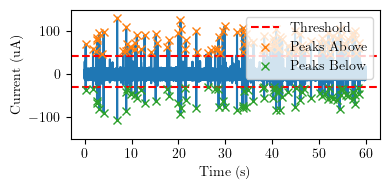

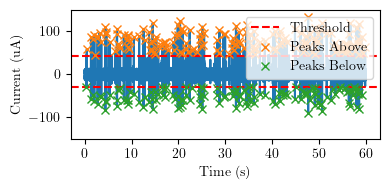

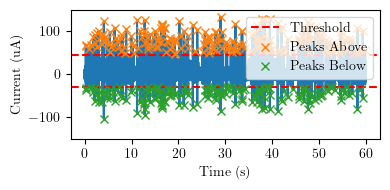

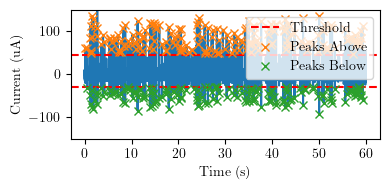

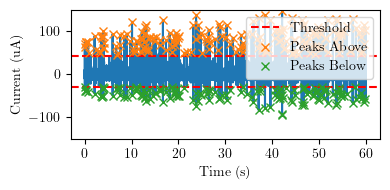

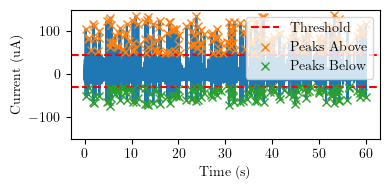

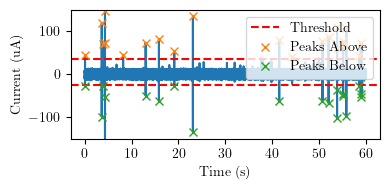

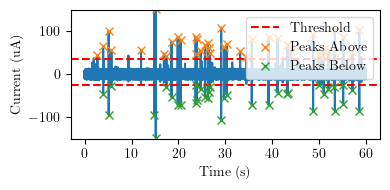

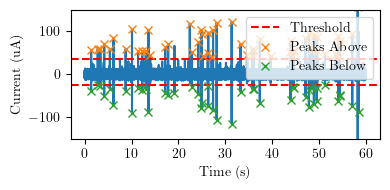

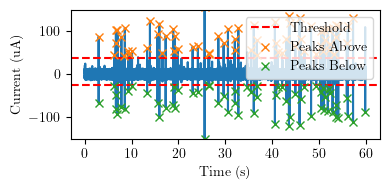

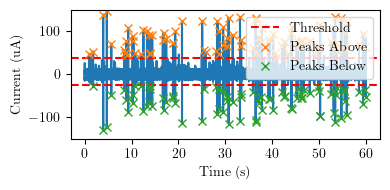

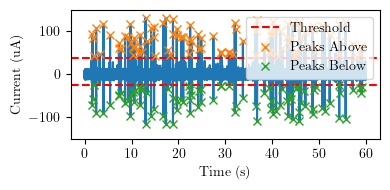

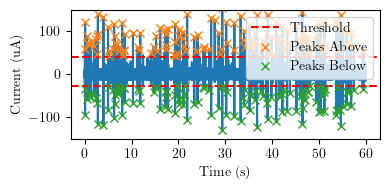

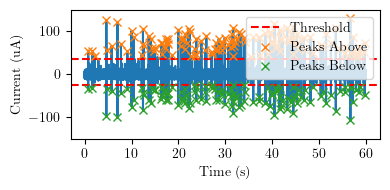

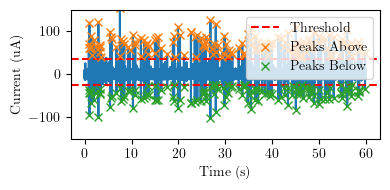

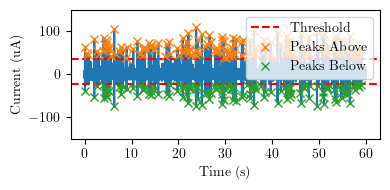

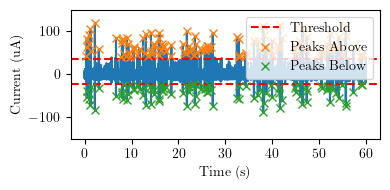

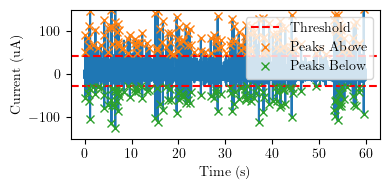

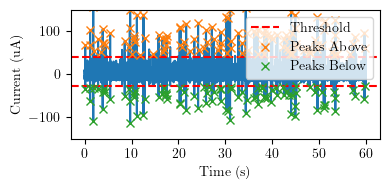

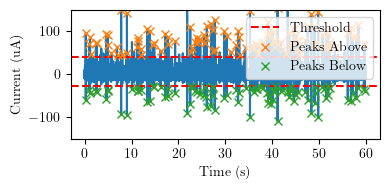

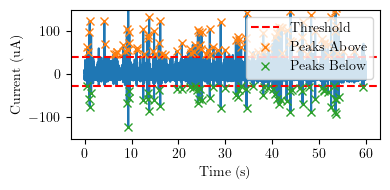

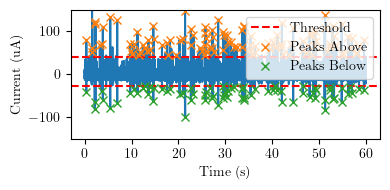

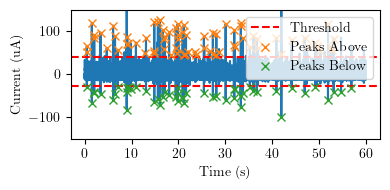

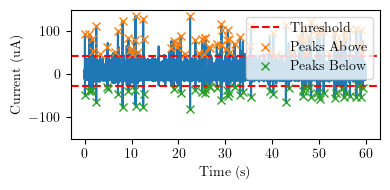

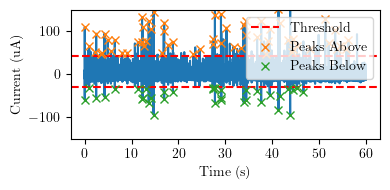

event_time  \
run_1   [[0.20518999999999998, 0.20519199999999999, 0....   
run_2   [[0.437532, 0.437534, 0.437536, 0.437538, 0.43...   
run_3   [[0.23163199999999998, 0.23163399999999998, 0....   
run_4   [[0.159718, 0.15972, 0.159722, 0.159724, 0.159...   
run_5   [[0.028426, 0.028428, 0.02843, 0.028432, 0.028...   
run_6   [[0.20585599999999998, 0.20585799999999999, 0....   
run_7   [[0.069354, 0.069356, 0.069358, 0.069359999999...   
run_8   [[2.70145, 2.7014519999999997, 2.701454, 2.701...   
run_9   [[1.37499, 1.374992, 1.3749939999999998, 1.374...   
run_10  [[2.973734, 2.9737359999999997, 2.973738, 2.97...   
run_11  [[0.9178759999999999, 0.917878, 0.917879999999...   
run_12  [[1.5749659999999999, 1.574968, 1.57497, 1.574...   
run_13  [[0.03345, 0.033451999999999996, 0.033454, 0.0...   
run_14  [[0.7533019999999999, 0.753304, 0.753305999999...   
run_15  [[0.87705, 0.8770519999999999, 0.877054, 0.877...   
run_16  [[0.066954, 0.066956, 0.066958, 0.066959999999...   
run_17  [[0.35021399999999997, 0.35021599999999997, 0....   
run_18  [[0.075542, 0.075544, 0.075546, 0.075547999999...   
run_19  [[0.112284, 0.112286, 0.112288, 0.11229, 0.112...   
run_20  [[0.222154, 0.222156, 0.222158, 0.22216, 0.222...   
run_21  [[0.54976, 0.549762, 0.549764, 0.549766, 0.549...   
run_22  [[0.337138, 0.33714, 0.337142, 0.337144, 0.337...   
run_23  [[0.42741399999999996, 0.42741599999999996, 0....   
run_24  [[0.049644, 0.049645999999999996, 0.049648, 0....   
run_25  [[0.009741999999999999, 0.009744, 0.009746, 0....   

                                               event_data  \
run_1   [[-0.27434392852768497, 0.1532653244020139, 0....   
run_2   [[-5.497137463379204, -5.863735974121369, -6.1...   
run_3   [[-1.845187490845035, -2.4865601715090975, -3....   
run_4   [[-1.934295654297216, -1.6901702880862217, -1....   
run_5   [[2.7516325820921566, 2.598846327209344, 2.293...   
run_6   [[-12.258566453552362, -12.045623948669572, -1...   
run_7   [[-2.7881042480461247, -3.001705932616403, -3....   
run_8   [[-3.7630859374992838, -4.31293334960867, -4.8...   
run_9   [[-7.261984252928755, -7.293136596678721, -7.2...   
run_10  [[-3.0311157226554997, -2.5429626464836588, -2...   
run_11  [[-6.158935546874034, -6.159713745116164, -6.2...   
run_12  [[-0.333084106444403, -0.4552276611319712, -0....   
run_13  [[1.77990722656358, 1.8105377197276766, 1.7495...   
run_14  [[-3.8401702880859716, -3.871072387695392, -3....   
run_15  [[-0.6915191650391534, -0.660833740234466, -0....   
run_16  [[-2.0961273315429025, -2.0962188842772207, -2...   
run_17  [[2.2414947509764716, 2.1193939208983466, 1.90...   
run_18  [[-5.781219482420568, -5.5987518310533915, -5....   
run_19  [[2.714340209962131, 3.386215209962131, 3.9361...   
run_20  [[-6.81432495117042, -6.235806274412596, -5.59...   
run_21  [[-3.3366790771472097, -3.580581665037812, -3....   
run_22  [[-3.8713775634753915, -4.115869140623829, -4....   
run_23  [[1.3946716308607847, 1.394409179688921, 1.272...   
run_24  [[4.184622244264347, 4.032016043092483, 3.6657...   
run_25  [[1.6945130004902467, 1.0543030395527921, 0.41...   

                                                      smo  sd_threshold  \
run_1   [[-0.4089278198126568, -0.5693838417791779, -0...     42.864772   
run_2   [[-5.671078365587402, -5.537154809167128, -5.3...     43.042526   
run_3   [[-1.9992752299769938, -2.098830445562241, -2....     44.380590   
run_4   [[-0.11033804989149272, -0.06768006693112205, ...     44.056876   
run_5   [[1.3920393768901231, 1.2748891324814164, 1.15...     43.355342   
run_6   [[-9.178884771473461, -8.846500802613537, -8.5...     43.976008   
run_7   [[-3.0479062710608504, -3.0672168430720377, -3...     36.167282   
run_8   [[-5.190040745216837, -5.286091735970577, -5.3...     36.261649   
run_9   [[-6.048639242876117, -5.829595231128388, -5.6...     36.784230   
run_10  [[-2.687899952996251, -2.7510067953534265, -2....     37.329940   
run_11  [[-5.678644378847641, -5.494423369570481

In [6]:
data_1_to_20_df3 = pd.DataFrame(columns = ["event_time", "event_data", "smo", "sd_threshold", "sd_threshold_lower", "mean_noise"])

for i in range(len(paths)):
    
    data = load_to_event_data_nofeatures(paths[i], resistive = True, plot = True, NRNS = True)
    
    # each col should be event_time, event_data ...
    # each row is a different path
    
    data_1_to_20_df3.loc[f"run_{i+1}"] = data
    
    
data_1_to_20_df3

### Discrete Wavelet Transform (DWT)

- Compare: training with DWT and without
    - more subject to overiftting?
    - takes longer/more computationally expensive?

- less computationally expensive than CWT
- https://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/
- https://blog.octo.com/time-series-features-extraction-using-fourier-and-wavelet-transforms-on-ecg-data/
- https://www.youtube.com/watch?v=fxfS0vSAsTA

- performing DWT and then reconstruction with a threshold for coefficients -> doesn't reconstruct the event perfectly but gets the general shape -> better for model generalisation and preventing overfitting

/var/folders/br/67qx_45113s31sykxddgpjyw0000gn/T/ipykernel_36240/1265269963.py:33: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


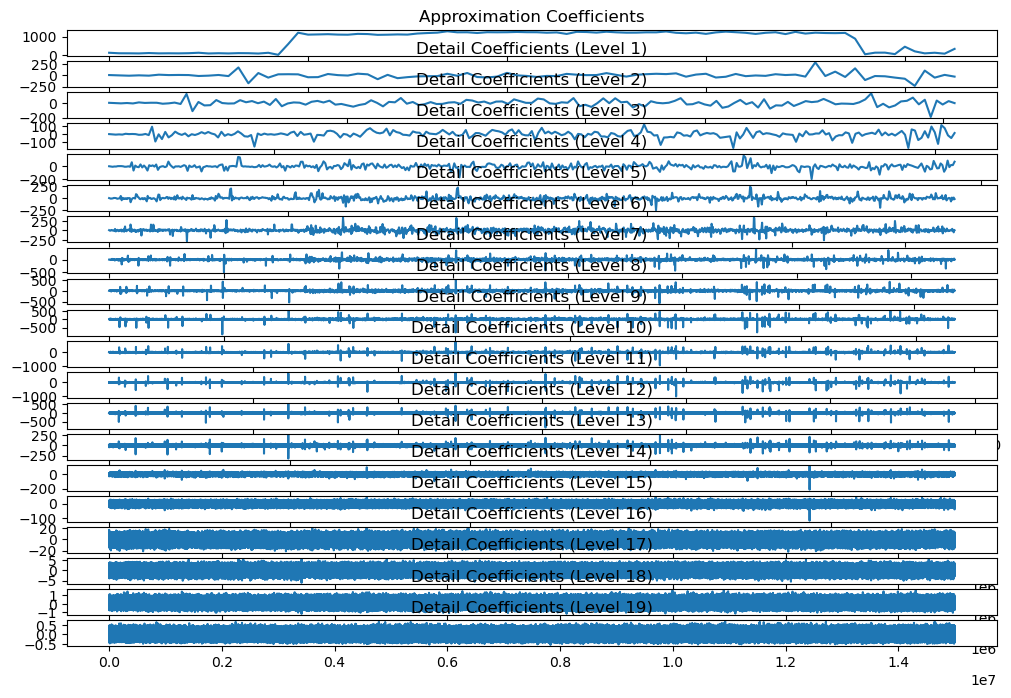

In [115]:
import pywt

wavelet = 'coif5'  # or another wavelet as 'sym5', 'coif5', etc.
max_level = pywt.dwt_max_level(len(y_base_nores), pywt.Wavelet(wavelet).dec_len)
coeffs = pywt.wavedec(y_base_nores, wavelet, level=max_level) # mutlilevel decomposition

# coeffs is a list where:
# coeffs[0] is the approximation coefficients (a) (only includes the approximation coefficients for 
# the lowest level as the approximation coefficients at each level are used to compute the detail 
# coefficients at the next level.)
# coeffs[1] is the detail coefficients at the highest level (d1)
# coeffs[2] is the detail coefficients at the second-highest level (d2)

features = []
for detail_coeffs in coeffs[1:]:  # Skip the approximation coefficients at index 0
    features.append(np.mean(detail_coeffs))
    features.append(np.var(detail_coeffs))
# Add more feature extraction as needed



plt.figure(figsize=(12, 8))
# Plot the approximation coefficients
plt.subplot(len(coeffs), 1, 1)
plt.plot(coeffs[0])
plt.title('Approximation Coefficients')

# Plot the detail coefficients
for i, detail_coeffs in enumerate(coeffs[1:], start=2):
    plt.subplot(len(coeffs), 1, i)
    plt.plot(detail_coeffs)
    plt.title(f'Detail Coefficients (Level {i-1})')
plt.tight_layout()
plt.show()


### DWT and feature extraction testing using just one wavelet

General function for DWT + reconstruction

In [35]:
def lowpassfilter(signal, thresh=0.3, wavelet="coif4"):
    thresh = thresh * np.nanmax(signal)
    coeffs = pywt.wavedec(signal, wavelet, mode="per")

    # Apply thresholding
    coeffs[1:] = [pywt.threshold(i, value=thresh, mode="soft") for i in coeffs[1:]] # was soft

    reconstructed_signal = pywt.waverec(coeffs, wavelet, mode="per")
    return reconstructed_signal, coeffs


In [68]:
def lowpassfilter2(signal, thresh=0.3, wavelet="coif4"):
    thresh = thresh * np.nanmax(signal)
    coeffs = pywt.wavedec(signal, wavelet, mode="per")

    # Apply thresholding
    #coeffs[0] = pywt.threshold(coeffs[0], value=thresh, mode="soft") # was soft
    coeffs = [pywt.threshold(i, value=thresh, mode="soft") for i in coeffs] # was soft

    reconstructed_signal = pywt.waverec(coeffs, wavelet, mode="per")
    return reconstructed_signal, coeffs

Testing thresholds

In [71]:
recsig, _ = lowpassfilter2(y_base_5nm_0002, thresh=0.1, wavelet="db36")


In [251]:
save_with_pickle('y_base_5nm_0002.pkl', y_base_5nm_0002)
save_with_pickle('event_data_5nm_0002.pkl', event_data_5nm_0002)

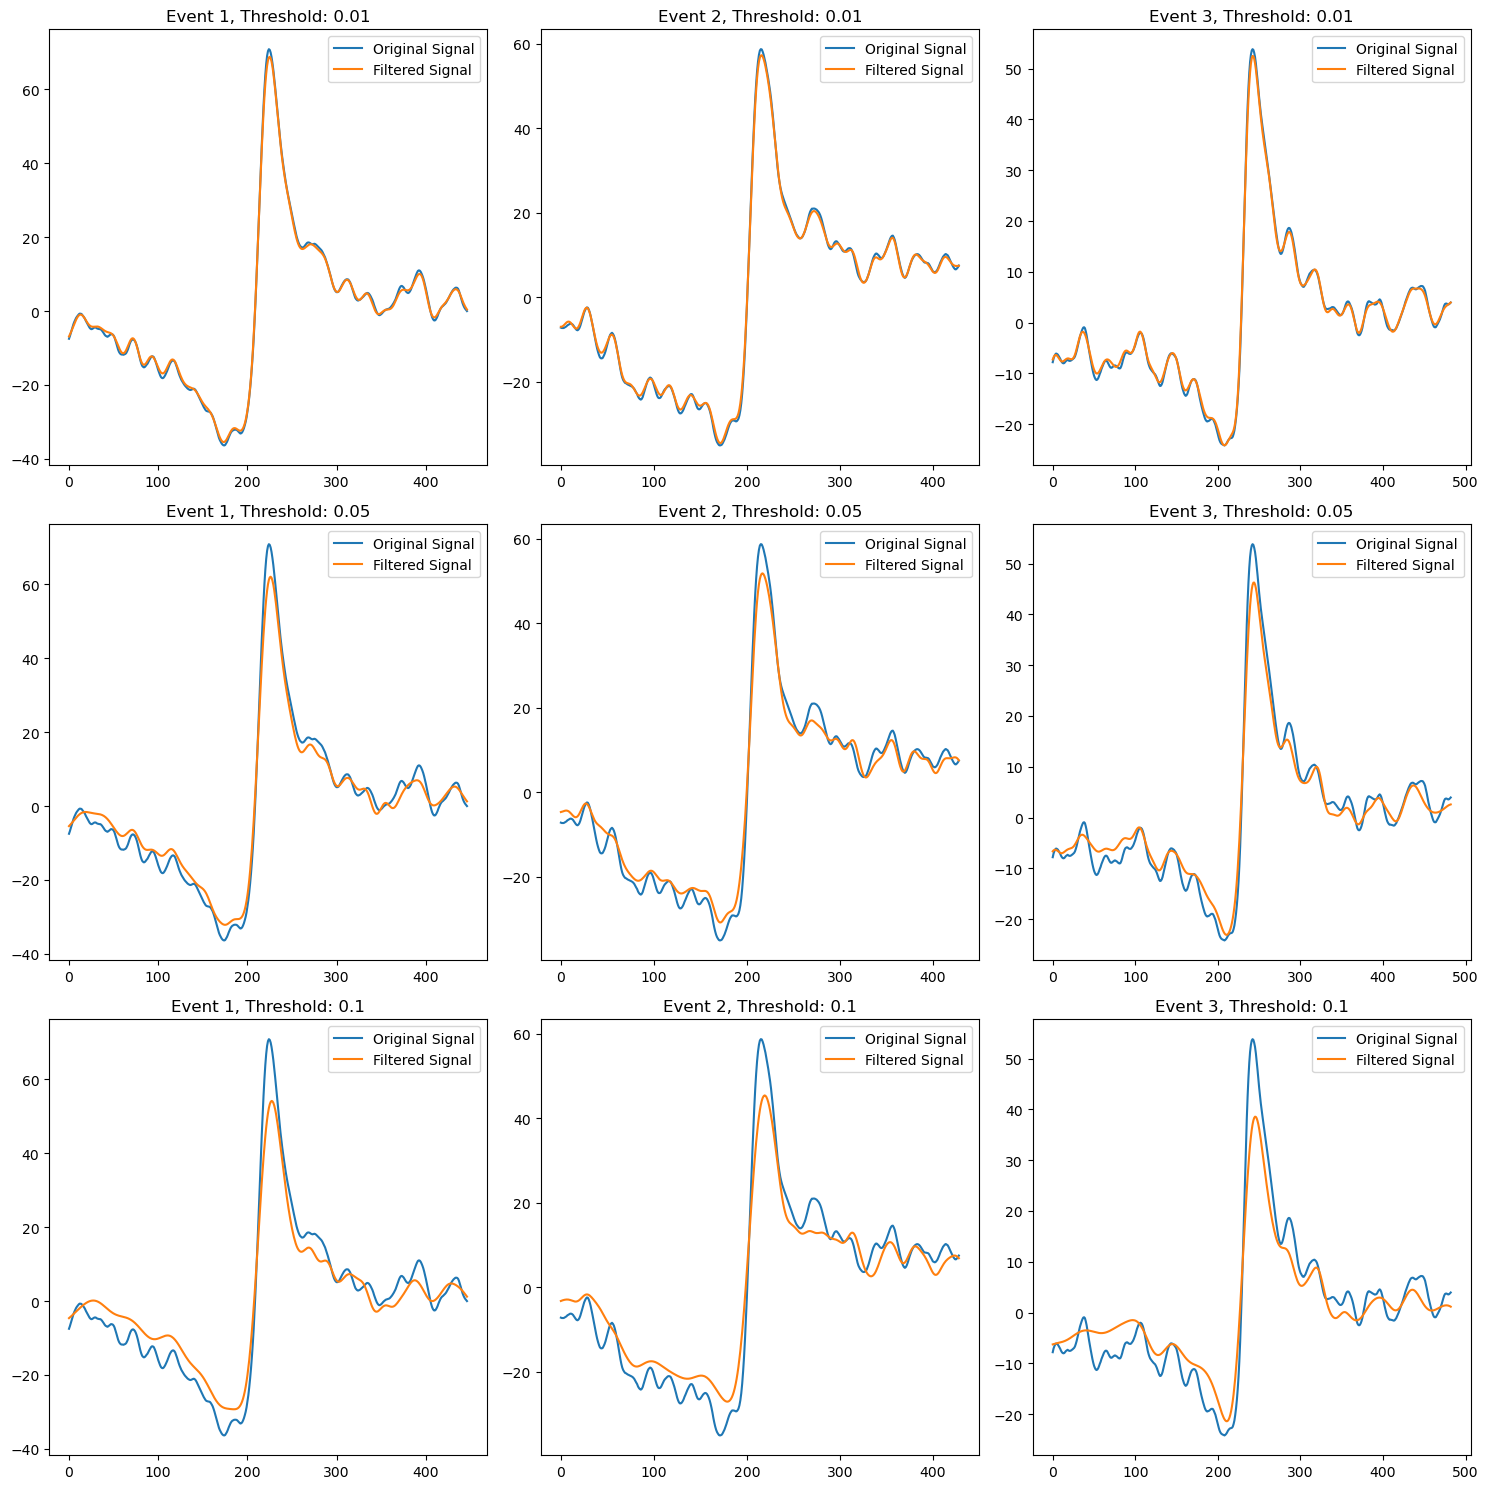

In [72]:
thresholds = [0.01, 0.05, 0.1]

fig, axs = plt.subplots(3, 3, figsize=(15, 15))

for i, thresh in enumerate(thresholds):
    for j in range(3):
        recsig, _ = lowpassfilter2(y_base_5nm_0002, thresh=thresh, wavelet="db36")
        
        start_idx = np.where(y_base_5nm_0002 == event_data_5nm_0002[j][0])[0][0]
        end_idx = np.where(y_base_5nm_0002 == event_data_5nm_0002[j][-1])[0][0]
        
        axs[i, j].plot(y_base_5nm_0002[start_idx:end_idx], label='Original Signal')
        
        axs[i, j].plot(recsig[start_idx:end_idx], label='Filtered Signal')
        
        axs[i, j].set_title(f'Event {j+1}, Threshold: {thresh}')
        axs[i, j].legend()

plt.tight_layout()
plt.show()

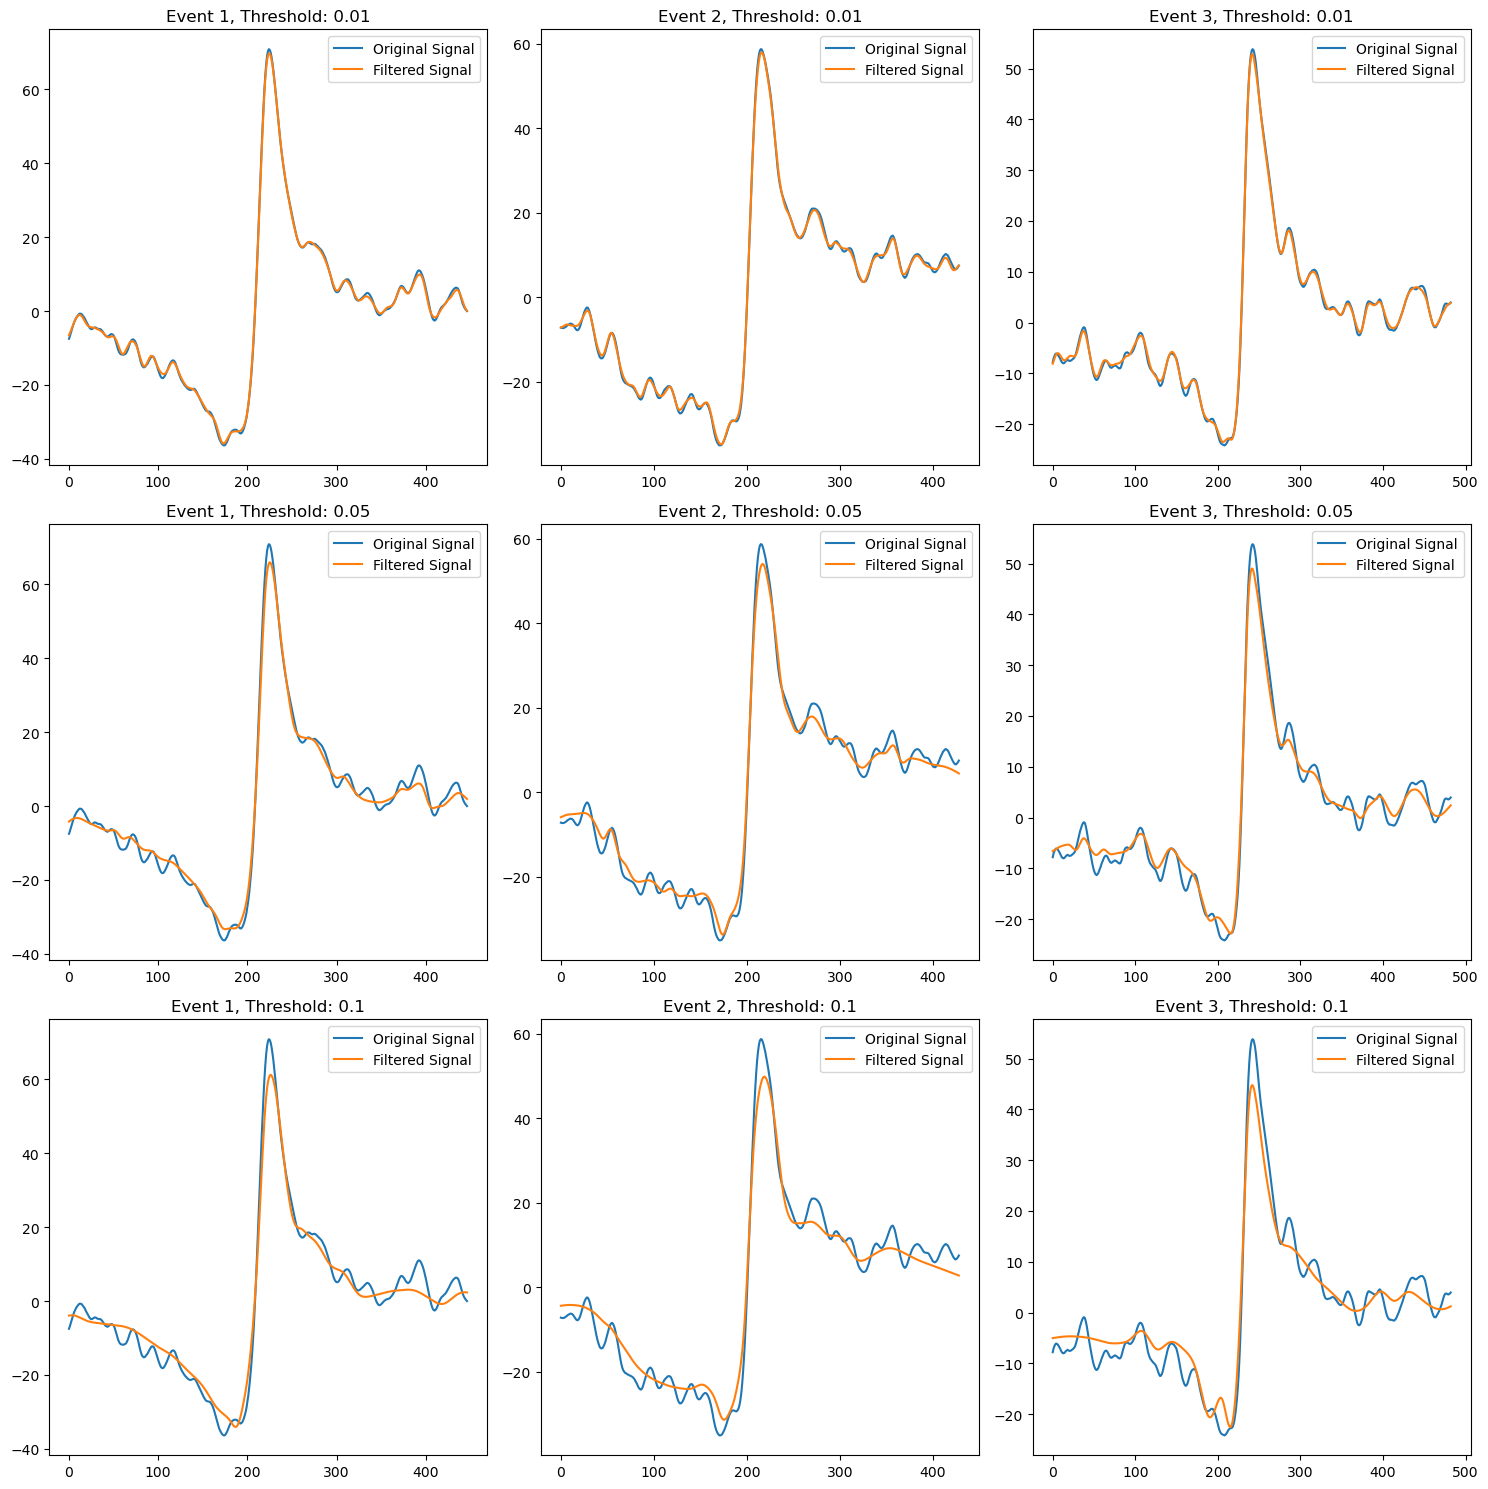

In [73]:
thresholds = [0.01, 0.05, 0.1]

fig, axs = plt.subplots(3, 3, figsize=(15, 15))

for i, thresh in enumerate(thresholds):
    for j in range(3):
        recsig, _ = lowpassfilter2(y_base_5nm_0002, thresh=thresh, wavelet="coif5")
        
        start_idx = np.where(y_base_5nm_0002 == event_data_5nm_0002[j][0])[0][0]
        end_idx = np.where(y_base_5nm_0002 == event_data_5nm_0002[j][-1])[0][0]
        
        axs[i, j].plot(y_base_5nm_0002[start_idx:end_idx], label='Original Signal')
        
        axs[i, j].plot(recsig[start_idx:end_idx], label='Filtered Signal')
        
        axs[i, j].set_title(f'Event {j+1}, Threshold: {thresh}')
        axs[i, j].legend()

plt.tight_layout()
plt.show()

DWT of each peak funcs

In [ ]:
def DWT_and_features(event_time, event_data, mean_noise, sd_threshold, sd_threshold_lower, NP_size):
    
    DWT_rec, all_coeffs = zip(*[lowpassfilter(signal) for signal in event_data])
    DWT_rec, all_coeffs = list(DWT_rec), list(all_coeffs)
    event_time_padded, DWT_rec_padded = pad_event(event_time, DWT_rec, mean_noise)
    features_df, features_list =  find_features(event_time_padded, DWT_rec_padded, mean_noise, all_coeffs, sd_threshold, sd_threshold_lower)
    if NP_size == 5:
        labels = list(np.zeros(len(features_list)))
    else:
        labels = list(np.ones(len(features_list)))
    
    return DWT_rec, event_time_padded, DWT_rec_padded, features_df, features_list, labels, all_coeffs

In [34]:
def noDWT_and_features(event_time, event_data, mean_noise, sd_threshold, sd_threshold_lower, NP_size):
    # perform DWT to get coefficient array dimensions (so you can still use the same functions)
    DWT_rec, all_coeffs = zip(*[lowpassfilter(signal) for signal in event_data])
    DWT_rec, all_coeffs = list(DWT_rec), list(all_coeffs)
    
    # set all_coeffs to zero
    all_coeffs = [[np.zeros(len(j)) for j in i] for i in all_coeffs]
    

    event_time_padded, event_data_padded = pad_event(event_time, event_data, mean_noise, 1000)
    features_df, features_list =  find_features(event_time_padded, event_data_padded, mean_noise, all_coeffs, sd_threshold, sd_threshold_lower)
    if NP_size == 5:
        labels = list(np.zeros(len(features_list)))
    else:
        labels = list(np.ones(len(features_list)))
    
    return event_time_padded, event_data_padded, features_df, features_list, labels, all_coeffs

In [ ]:
import pywt

## Feature extraction

DWT

In [ ]:
DWT_rec_5nm_0002, event_time_padded_5nm_0002, DWT_rec_padded_5nm_0002, features_5nm_0002_df, features_5nm_0002_list, labels_5nm_0002, all_coeffs_5nm_0002 = DWT_and_features(event_time_5nm_0002, event_data_5nm_0002, mean_noise_5nm_0002, sd_threshold_5nm_0002, sd_threshold_lower_5nm_0002, 5)
DWT_rec_5nm_0003, event_time_padded_5nm_0003, DWT_rec_padded_5nm_0003, features_5nm_0003_df, features_5nm_0003_list, labels_5nm_0003, all_coeffs_5nm_0003 = DWT_and_features(event_time_5nm_0003, event_data_5nm_0003, mean_noise_5nm_0003, sd_threshold_5nm_0003, sd_threshold_lower_5nm_0003, 5)
DWT_rec_5nm_0004, event_time_padded_5nm_0004, DWT_rec_padded_5nm_0004, features_5nm_0004_df, features_5nm_0004_list, labels_5nm_0004, all_coeffs_5nm_0004 = DWT_and_features(event_time_5nm_0004, event_data_5nm_0004, mean_noise_5nm_0004, sd_threshold_5nm_0004, sd_threshold_lower_5nm_0004, 5)
DWT_rec_5nm_0005, event_time_padded_5nm_0005, DWT_rec_padded_5nm_0005, features_5nm_0005_df, features_5nm_0005_list, labels_5nm_0005, all_coeffs_5nm_0005 = DWT_and_features(event_time_5nm_0005, event_data_5nm_0005, mean_noise_5nm_0005, sd_threshold_5nm_0005, sd_threshold_lower_5nm_0005, 5)
DWT_rec_5nm_0006, event_time_padded_5nm_0006, DWT_rec_padded_5nm_0006, features_5nm_0006_df, features_5nm_0006_list, labels_5nm_0006, all_coeffs_5nm_0006 = DWT_and_features(event_time_5nm_0006, event_data_5nm_0006, mean_noise_5nm_0006, sd_threshold_5nm_0006, sd_threshold_lower_5nm_0006, 5)
DWT_rec_5nm_0007, event_time_padded_5nm_0007, DWT_rec_padded_5nm_0007, features_5nm_0007_df, features_5nm_0007_list, labels_5nm_0007, all_coeffs_5nm_0007 = DWT_and_features(event_time_5nm_0007, event_data_5nm_0007, mean_noise_5nm_0007, sd_threshold_5nm_0007, sd_threshold_lower_5nm_0007, 5)


In [ ]:
# 10nm (~7 seconds to run)
DWT_rec_10nm_0002, event_time_padded_10nm_0002, DWT_rec_padded_10nm_0002, features_10nm_0002_df, features_10nm_0002_list, labels_10nm_0002, all_coeffs_10nm_0002 = DWT_and_features(event_time_10nm_0002, event_data_10nm_0002, mean_noise_10nm_0002, sd_threshold_10nm_0002, sd_threshold_lower_10nm_0002, 10)
DWT_rec_10nm_0003, event_time_padded_10nm_0003, DWT_rec_padded_10nm_0003, features_10nm_0003_df, features_10nm_0003_list, labels_10nm_0003, all_coeffs_10nm_0003 = DWT_and_features(event_time_10nm_0003, event_data_10nm_0003, mean_noise_10nm_0003, sd_threshold_10nm_0003, sd_threshold_lower_10nm_0003, 10)
DWT_rec_10nm_0004, event_time_padded_10nm_0004, DWT_rec_padded_10nm_0004, features_10nm_0004_df, features_10nm_0004_list, labels_10nm_0004, all_coeffs_10nm_0004 = DWT_and_features(event_time_10nm_0004, event_data_10nm_0004, mean_noise_10nm_0004, sd_threshold_10nm_0004, sd_threshold_lower_10nm_0004, 10)
DWT_rec_10nm_0005, event_time_padded_10nm_0005, DWT_rec_padded_10nm_0005, features_10nm_0005_df, features_10nm_0005_list, labels_10nm_0005, all_coeffs_10nm_0005 = DWT_and_features(event_time_10nm_0005, event_data_10nm_0005, mean_noise_10nm_0005, sd_threshold_10nm_0005, sd_threshold_lower_10nm_0005, 10)
DWT_rec_10nm_0006, event_time_padded_10nm_0006, DWT_rec_padded_10nm_0006, features_10nm_0006_df, features_10nm_0006_list, labels_10nm_0006, all_coeffs_10nm_0006 = DWT_and_features(event_time_10nm_0006, event_data_10nm_0006, mean_noise_10nm_0006, sd_threshold_10nm_0006, sd_threshold_lower_10nm_0006, 10)
DWT_rec_10nm_0007, event_time_padded_10nm_0007, DWT_rec_padded_10nm_0007, features_10nm_0007_df, features_10nm_0007_list, labels_10nm_0007, all_coeffs_10nm_0007 = DWT_and_features(event_time_10nm_0007, event_data_10nm_0007, mean_noise_10nm_0007, sd_threshold_10nm_0007, sd_threshold_lower_10nm_0007, 10)
DWT_rec_10nm_0008, event_time_padded_10nm_0008, DWT_rec_padded_10nm_0008, features_10nm_0008_df, features_10nm_0008_list, labels_10nm_0008, all_coeffs_10nm_0008 = DWT_and_features(event_time_10nm_0008, event_data_10nm_0008, mean_noise_10nm_0008, sd_threshold_10nm_0008, sd_threshold_lower_10nm_0008, 10)
DWT_rec_10nm_0009, event_time_padded_10nm_0009, DWT_rec_padded_10nm_0009, features_10nm_0009_df, features_10nm_0009_list, labels_10nm_0009, all_coeffs_10nm_0009 = DWT_and_features(event_time_10nm_0009, event_data_10nm_0009, mean_noise_10nm_0009, sd_threshold_10nm_0009, sd_threshold_lower_10nm_0009, 10)
DWT_rec_10nm_0010, event_time_padded_10nm_0010, DWT_rec_padded_10nm_0010, features_10nm_0010_df, features_10nm_0010_list, labels_10nm_0010, all_coeffs_10nm_0010 = DWT_and_features(event_time_10nm_0010, event_data_10nm_0010, mean_noise_10nm_0010, sd_threshold_10nm_0010, sd_threshold_lower_10nm_0010, 10)
DWT_rec_10nm_0011, event_time_padded_10nm_0011, DWT_rec_padded_10nm_0011, features_10nm_0011_df, features_10nm_0011_list, labels_10nm_0011, all_coeffs_10nm_0011 = DWT_and_features(event_time_10nm_0011, event_data_10nm_0011, mean_noise_10nm_0011, sd_threshold_10nm_0011, sd_threshold_lower_10nm_0011, 10)
DWT_rec_10nm_0012, event_time_padded_10nm_0012, DWT_rec_padded_10nm_0012, features_10nm_0012_df, features_10nm_0012_list, labels_10nm_0012, all_coeffs_10nm_0012 = DWT_and_features(event_time_10nm_0012, event_data_10nm_0012, mean_noise_10nm_0012, sd_threshold_10nm_0012, sd_threshold_lower_10nm_0012, 10)
DWT_rec_10nm_0013, event_time_padded_10nm_0013, DWT_rec_padded_10nm_0013, features_10nm_0013_df, features_10nm_0013_list, labels_10nm_0013, all_coeffs_10nm_0013 = DWT_and_features(event_time_10nm_0013, event_data_10nm_0013, mean_noise_10nm_0013, sd_threshold_10nm_0013, sd_threshold_lower_10nm_0013, 10)
DWT_rec_10nm_0014, event_time_padded_10nm_0014, DWT_rec_padded_10nm_0014, features_10nm_0014_df, features_10nm_0014_list, labels_10nm_0014, all_coeffs_10nm_0014 = DWT_and_features(event_time_10nm_0014, event_data_10nm_0014, mean_noise_10nm_0014, sd_threshold_10nm_0014, sd_threshold_lower_10nm_0014, 10)
DWT_rec_10nm_0015, event_time_padded_10nm_0015, DWT_rec_padded_10nm_0015, features_10nm_0015_df, features_10nm_0015_list, labels_10nm_0015, all_coeffs_10nm_0015 = DWT_and_features(event_time_10nm_0015, event_data_10nm_0015, mean_noise_10nm_0015, sd_threshold_10nm_0015, sd_threshold_lower_10nm_0015, 10)
DWT_rec_10nm_0016, event_time_padded_10nm_0016, DWT_rec_padded_10nm_0016, features_10nm_0016_df, features_10nm_0016_list, labels_10nm_0016, all_coeffs_10nm_0016 = DWT_and_features(event_time_10nm_0016, event_data_10nm_0016, mean_noise_10nm_0016, sd_threshold_10nm_0016, sd_threshold_lower_10nm_0016, 10)
DWT_rec_10nm_0017, event_time_padded_10nm_0017, DWT_rec_padded_10nm_0017, features_10nm_0017_df, features_10nm_0017_list, labels_10nm_0017, all_coeffs_10nm_0017 = DWT_and_features(event_time_10nm_0017, event_data_10nm_0017, mean_noise_10nm_0017, sd_threshold_10nm_0017, sd_threshold_lower_10nm_0017, 10)
DWT_rec_10nm_0018, event_time_padded_10nm_0018, DWT_rec_padded_10nm_0018, features_10nm_0018_df, features_10nm_0018_list, labels_10nm_0018, all_coeffs_10nm_0018 = DWT_and_features(event_time_10nm_0018, event_data_10nm_0018, mean_noise_10nm_0018, sd_threshold_10nm_0018, sd_threshold_lower_10nm_0018, 10)
DWT_rec_10nm_0019, event_time_padded_10nm_0019, DWT_rec_padded_10nm_0019, features_10nm_0019_df, features_10nm_0019_list, labels_10nm_0019, all_coeffs_10nm_0019 = DWT_and_features(event_time_10nm_0019, event_data_10nm_0019, mean_noise_10nm_0019, sd_threshold_10nm_0019, sd_threshold_lower_10nm_0019, 10)
DWT_rec_10nm_0020, event_time_padded_10nm_0020, DWT_rec_padded_10nm_0020, features_10nm_0020_df, features_10nm_0020_list, labels_10nm_0020, all_coeffs_10nm_0020 = DWT_and_features(event_time_10nm_0020, event_data_10nm_0020, mean_noise_10nm_0020, sd_threshold_10nm_0020, sd_threshold_lower_10nm_0020, 10)

no DWT

In [ ]:
noDWT_event_time_padded_5nm_0002, noDWT_event_data_padded_5nm_0002, noDWT_features_5nm_0002_df, noDWT_features_5nm_0002_list, noDWT_labels_5nm_0002, noDWT_all_coeffs_5nm_0002 = noDWT_and_features(event_time_5nm_0002, event_data_5nm_0002, mean_noise_5nm_0002, sd_threshold_5nm_0002, sd_threshold_lower_5nm_0002, 5)
noDWT_event_time_padded_5nm_0003, noDWT_event_data_padded_5nm_0003, noDWT_features_5nm_0003_df, noDWT_features_5nm_0003_list, noDWT_labels_5nm_0003, noDWT_all_coeffs_5nm_0003 = noDWT_and_features(event_time_5nm_0003, event_data_5nm_0003, mean_noise_5nm_0003, sd_threshold_5nm_0003, sd_threshold_lower_5nm_0003, 5)
noDWT_event_time_padded_5nm_0004, noDWT_event_data_padded_5nm_0004, noDWT_features_5nm_0004_df, noDWT_features_5nm_0004_list, noDWT_labels_5nm_0004, noDWT_all_coeffs_5nm_0004 = noDWT_and_features(event_time_5nm_0004, event_data_5nm_0004, mean_noise_5nm_0004, sd_threshold_5nm_0004, sd_threshold_lower_5nm_0004, 5)
noDWT_event_time_padded_5nm_0005, noDWT_event_data_padded_5nm_0005, noDWT_features_5nm_0005_df, noDWT_features_5nm_0005_list, noDWT_labels_5nm_0005, noDWT_all_coeffs_5nm_0005 = noDWT_and_features(event_time_5nm_0005, event_data_5nm_0005, mean_noise_5nm_0005, sd_threshold_5nm_0005, sd_threshold_lower_5nm_0005, 5)
noDWT_event_time_padded_5nm_0006, noDWT_event_data_padded_5nm_0006, noDWT_features_5nm_0006_df, noDWT_features_5nm_0006_list, noDWT_labels_5nm_0006, noDWT_all_coeffs_5nm_0006 = noDWT_and_features(event_time_5nm_0006, event_data_5nm_0006, mean_noise_5nm_0006, sd_threshold_5nm_0006, sd_threshold_lower_5nm_0006, 5)
noDWT_event_time_padded_5nm_0007, noDWT_event_data_padded_5nm_0007, noDWT_features_5nm_0007_df, noDWT_features_5nm_0007_list, noDWT_labels_5nm_0007, noDWT_all_coeffs_5nm_0007 = noDWT_and_features(event_time_5nm_0007, event_data_5nm_0007, mean_noise_5nm_0007, sd_threshold_5nm_0007, sd_threshold_lower_5nm_0007, 5)

noDWT_event_time_padded_10nm_0002, noDWT_event_data_padded_10nm_0002, noDWT_features_10nm_0002_df, noDWT_features_10nm_0002_list, noDWT_labels_10nm_0002, noDWT_all_coeffs_10nm_0002 = noDWT_and_features(event_time_10nm_0002, event_data_10nm_0002, mean_noise_10nm_0002, sd_threshold_10nm_0002, sd_threshold_lower_10nm_0002, 10)
noDWT_event_time_padded_10nm_0003, noDWT_event_data_padded_10nm_0003, noDWT_features_10nm_0003_df, noDWT_features_10nm_0003_list, noDWT_labels_10nm_0003, noDWT_all_coeffs_10nm_0003 = noDWT_and_features(event_time_10nm_0003, event_data_10nm_0003, mean_noise_10nm_0003, sd_threshold_10nm_0003, sd_threshold_lower_10nm_0003, 10)
noDWT_event_time_padded_10nm_0004, noDWT_event_data_padded_10nm_0004, noDWT_features_10nm_0004_df, noDWT_features_10nm_0004_list, noDWT_labels_10nm_0004, noDWT_all_coeffs_10nm_0004 = noDWT_and_features(event_time_10nm_0004, event_data_10nm_0004, mean_noise_10nm_0004, sd_threshold_10nm_0004, sd_threshold_lower_10nm_0004, 10)
noDWT_event_time_padded_10nm_0005, noDWT_event_data_padded_10nm_0005, noDWT_features_10nm_0005_df, noDWT_features_10nm_0005_list, noDWT_labels_10nm_0005, noDWT_all_coeffs_10nm_0005 = noDWT_and_features(event_time_10nm_0005, event_data_10nm_0005, mean_noise_10nm_0005, sd_threshold_10nm_0005, sd_threshold_lower_10nm_0005, 10)
noDWT_event_time_padded_10nm_0006, noDWT_event_data_padded_10nm_0006, noDWT_features_10nm_0006_df, noDWT_features_10nm_0006_list, noDWT_labels_10nm_0006, noDWT_all_coeffs_10nm_0006 = noDWT_and_features(event_time_10nm_0006, event_data_10nm_0006, mean_noise_10nm_0006, sd_threshold_10nm_0006, sd_threshold_lower_10nm_0006, 10)
noDWT_event_time_padded_10nm_0007, noDWT_event_data_padded_10nm_0007, noDWT_features_10nm_0007_df, noDWT_features_10nm_0007_list, noDWT_labels_10nm_0007, noDWT_all_coeffs_10nm_0007 = noDWT_and_features(event_time_10nm_0007, event_data_10nm_0007, mean_noise_10nm_0007, sd_threshold_10nm_0007, sd_threshold_lower_10nm_0007, 10)
noDWT_event_time_padded_10nm_0008, noDWT_event_data_padded_10nm_0008, noDWT_features_10nm_0008_df, noDWT_features_10nm_0008_list, noDWT_labels_10nm_0008, noDWT_all_coeffs_10nm_0008 = noDWT_and_features(event_time_10nm_0008, event_data_10nm_0008, mean_noise_10nm_0008, sd_threshold_10nm_0008, sd_threshold_lower_10nm_0008, 10)
noDWT_event_time_padded_10nm_0009, noDWT_event_data_padded_10nm_0009, noDWT_features_10nm_0009_df, noDWT_features_10nm_0009_list, noDWT_labels_10nm_0009, noDWT_all_coeffs_10nm_0009 = noDWT_and_features(event_time_10nm_0009, event_data_10nm_0009, mean_noise_10nm_0009, sd_threshold_10nm_0009, sd_threshold_lower_10nm_0009, 10)
noDWT_event_time_padded_10nm_0010, noDWT_event_data_padded_10nm_0010, noDWT_features_10nm_0010_df, noDWT_features_10nm_0010_list, noDWT_labels_10nm_0010, noDWT_all_coeffs_10nm_0010 = noDWT_and_features(event_time_10nm_0010, event_data_10nm_0010, mean_noise_10nm_0010, sd_threshold_10nm_0010, sd_threshold_lower_10nm_0010, 10)
noDWT_event_time_padded_10nm_0011, noDWT_event_data_padded_10nm_0011, noDWT_features_10nm_0011_df, noDWT_features_10nm_0011_list, noDWT_labels_10nm_0011, noDWT_all_coeffs_10nm_0011 = noDWT_and_features(event_time_10nm_0011, event_data_10nm_0011, mean_noise_10nm_0011, sd_threshold_10nm_0011, sd_threshold_lower_10nm_0011, 10)
noDWT_event_time_padded_10nm_0012, noDWT_event_data_padded_10nm_0012, noDWT_features_10nm_0012_df, noDWT_features_10nm_0012_list, noDWT_labels_10nm_0012, noDWT_all_coeffs_10nm_0012 = noDWT_and_features(event_time_10nm_0012, event_data_10nm_0012, mean_noise_10nm_0012, sd_threshold_10nm_0012, sd_threshold_lower_10nm_0012, 10)
noDWT_event_time_padded_10nm_0013, noDWT_event_data_padded_10nm_0013, noDWT_features_10nm_0013_df, noDWT_features_10nm_0013_list, noDWT_labels_10nm_0013, noDWT_all_coeffs_10nm_0013 = noDWT_and_features(event_time_10nm_0013, event_data_10nm_0013, mean_noise_10nm_0013, sd_threshold_10nm_0013, sd_threshold_lower_10nm_0013, 10)
noDWT_event_time_padded_10nm_0014, noDWT_event_data_padded_10nm_0014, noDWT_features_10nm_0014_df, noDWT_features_10nm_0014_list, noDWT_labels_10nm_0014, noDWT_all_coeffs_10nm_0014 = noDWT_and_features(event_time_10nm_0014, event_data_10nm_0014, mean_noise_10nm_0014, sd_threshold_10nm_0014, sd_threshold_lower_10nm_0014, 10)
noDWT_event_time_padded_10nm_0015, noDWT_event_data_padded_10nm_0015, noDWT_features_10nm_0015_df, noDWT_features_10nm_0015_list, noDWT_labels_10nm_0015, noDWT_all_coeffs_10nm_0015 = noDWT_and_features(event_time_10nm_0015, event_data_10nm_0015, mean_noise_10nm_0015, sd_threshold_10nm_0015, sd_threshold_lower_10nm_0015, 10)
noDWT_event_time_padded_10nm_0016, noDWT_event_data_padded_10nm_0016, noDWT_features_10nm_0016_df, noDWT_features_10nm_0016_list, noDWT_labels_10nm_0016, noDWT_all_coeffs_10nm_0016 = noDWT_and_features(event_time_10nm_0016, event_data_10nm_0016, mean_noise_10nm_0016, sd_threshold_10nm_0016, sd_threshold_lower_10nm_0016, 10)
noDWT_event_time_padded_10nm_0017, noDWT_event_data_padded_10nm_0017, noDWT_features_10nm_0017_df, noDWT_features_10nm_0017_list, noDWT_labels_10nm_0017, noDWT_all_coeffs_10nm_0017 = noDWT_and_features(event_time_10nm_0017, event_data_10nm_0017, mean_noise_10nm_0017, sd_threshold_10nm_0017, sd_threshold_lower_10nm_0017, 10)
noDWT_event_time_padded_10nm_0018, noDWT_event_data_padded_10nm_0018, noDWT_features_10nm_0018_df, noDWT_features_10nm_0018_list, noDWT_labels_10nm_0018, noDWT_all_coeffs_10nm_0018 = noDWT_and_features(event_time_10nm_0018, event_data_10nm_0018, mean_noise_10nm_0018, sd_threshold_10nm_0018, sd_threshold_lower_10nm_0018, 10)
noDWT_event_time_padded_10nm_0019, noDWT_event_data_padded_10nm_0019, noDWT_features_10nm_0019_df, noDWT_features_10nm_0019_list, noDWT_labels_10nm_0019, noDWT_all_coeffs_10nm_0019 = noDWT_and_features(event_time_10nm_0019, event_data_10nm_0019, mean_noise_10nm_0019, sd_threshold_10nm_0019, sd_threshold_lower_10nm_0019, 10)
noDWT_event_time_padded_10nm_0020, noDWT_event_data_padded_10nm_0020, noDWT_features_10nm_0020_df, noDWT_features_10nm_0020_list, noDWT_labels_10nm_0020, noDWT_all_coeffs_10nm_0020 = noDWT_and_features(event_time_10nm_0020, event_data_10nm_0020, mean_noise_10nm_0020, sd_threshold_10nm_0020, sd_threshold_lower_10nm_0020, 10)

In [5]:
event_times_all = unpickle("data_1_to_20_df3.pkl")["event_time"]
event_datas_all = unpickle("data_1_to_20_df3.pkl")["event_data"]
mean_noises_all = unpickle("data_1_to_20_df3.pkl")["mean_noise"]
sd_thresholds_all = unpickle("data_1_to_20_df3.pkl")["sd_threshold"]
sd_thresholds_lower_all = unpickle("data_1_to_20_df3.pkl")["sd_threshold_lower"]


In [122]:
def noDWT_and_features(event_time, event_data, mean_noise, sd_threshold, sd_threshold_lower, NP_size):
    # perform DWT to get coefficient array dimensions (so you can still use the same functions)
    DWT_rec, all_coeffs = zip(*[lowpassfilter(signal) for signal in event_data])
    DWT_rec, all_coeffs = list(DWT_rec), list(all_coeffs)
    
    # set all_coeffs to zero
    all_coeffs = [[np.zeros(len(j)) for j in i] for i in all_coeffs]
    

    event_time_padded, event_data_padded = pad_event_transition(event_time, event_data, mean_noise, sd_noise=2, custom_length=1000, transition_fraction = 0.2, noise_frequency=5)
    features_df, features_list =  find_features(event_time_padded, event_data_padded, mean_noise, all_coeffs, sd_threshold, sd_threshold_lower)
    if NP_size == 5:
        labels = list(np.zeros(len(features_list)))
    else:
        labels = list(np.ones(len(features_list)))
    
    return event_time_padded, event_data_padded, features_df, features_list, labels, all_coeffs

In [123]:
noDWT_event_time_padded_5nm_0002, noDWT_event_data_padded_5nm_0002, noDWT_features_5nm_0002_df, noDWT_features_5nm_0002_list, noDWT_labels_5nm_0002, noDWT_all_coeffs_5nm_0002 = noDWT_and_features(event_times_all[0], event_datas_all[0], mean_noises_all[0], sd_thresholds_all[0], sd_thresholds_lower_all[0], 5)
noDWT_event_time_padded_5nm_0003, noDWT_event_data_padded_5nm_0003, noDWT_features_5nm_0003_df, noDWT_features_5nm_0003_list, noDWT_labels_5nm_0003, noDWT_all_coeffs_5nm_0003 = noDWT_and_features(event_times_all[1], event_datas_all[1], mean_noises_all[1], sd_thresholds_all[1], sd_thresholds_lower_all[1], 5)
noDWT_event_time_padded_5nm_0004, noDWT_event_data_padded_5nm_0004, noDWT_features_5nm_0004_df, noDWT_features_5nm_0004_list, noDWT_labels_5nm_0004, noDWT_all_coeffs_5nm_0004 = noDWT_and_features(event_times_all[2], event_datas_all[2], mean_noises_all[2], sd_thresholds_all[2], sd_thresholds_lower_all[2], 5)
noDWT_event_time_padded_5nm_0005, noDWT_event_data_padded_5nm_0005, noDWT_features_5nm_0005_df, noDWT_features_5nm_0005_list, noDWT_labels_5nm_0005, noDWT_all_coeffs_5nm_0005 = noDWT_and_features(event_times_all[3], event_datas_all[3], mean_noises_all[3], sd_thresholds_all[3], sd_thresholds_lower_all[3], 5)
noDWT_event_time_padded_5nm_0006, noDWT_event_data_padded_5nm_0006, noDWT_features_5nm_0006_df, noDWT_features_5nm_0006_list, noDWT_labels_5nm_0006, noDWT_all_coeffs_5nm_0006 = noDWT_and_features(event_times_all[4], event_datas_all[4], mean_noises_all[4], sd_thresholds_all[4], sd_thresholds_lower_all[4], 5)
noDWT_event_time_padded_5nm_0007, noDWT_event_data_padded_5nm_0007, noDWT_features_5nm_0007_df, noDWT_features_5nm_0007_list, noDWT_labels_5nm_0007, noDWT_all_coeffs_5nm_0007 = noDWT_and_features(event_times_all[5], event_datas_all[5], mean_noises_all[5], sd_thresholds_all[5], sd_thresholds_lower_all[5], 5)

noDWT_event_time_padded_10nm_0002, noDWT_event_data_padded_10nm_0002, noDWT_features_10nm_0002_df, noDWT_features_10nm_0002_list, noDWT_labels_10nm_0002, noDWT_all_coeffs_10nm_0002 = noDWT_and_features(event_times_all[6], event_datas_all[6], mean_noises_all[6], sd_thresholds_all[6], sd_thresholds_lower_all[6], 10)
noDWT_event_time_padded_10nm_0003, noDWT_event_data_padded_10nm_0003, noDWT_features_10nm_0003_df, noDWT_features_10nm_0003_list, noDWT_labels_10nm_0003, noDWT_all_coeffs_10nm_0003 = noDWT_and_features(event_times_all[7], event_datas_all[7], mean_noises_all[7], sd_thresholds_all[7], sd_thresholds_lower_all[7], 10)
noDWT_event_time_padded_10nm_0004, noDWT_event_data_padded_10nm_0004, noDWT_features_10nm_0004_df, noDWT_features_10nm_0004_list, noDWT_labels_10nm_0004, noDWT_all_coeffs_10nm_0004 = noDWT_and_features(event_times_all[8], event_datas_all[8], mean_noises_all[8], sd_thresholds_all[8], sd_thresholds_lower_all[8], 10)
noDWT_event_time_padded_10nm_0005, noDWT_event_data_padded_10nm_0005, noDWT_features_10nm_0005_df, noDWT_features_10nm_0005_list, noDWT_labels_10nm_0005, noDWT_all_coeffs_10nm_0005 = noDWT_and_features(event_times_all[9], event_datas_all[9], mean_noises_all[9], sd_thresholds_all[9], sd_thresholds_lower_all[9], 10)
noDWT_event_time_padded_10nm_0006, noDWT_event_data_padded_10nm_0006, noDWT_features_10nm_0006_df, noDWT_features_10nm_0006_list, noDWT_labels_10nm_0006, noDWT_all_coeffs_10nm_0006 = noDWT_and_features(event_times_all[10], event_datas_all[10], mean_noises_all[10], sd_thresholds_all[10], sd_thresholds_lower_all[10], 10)
noDWT_event_time_padded_10nm_0007, noDWT_event_data_padded_10nm_0007, noDWT_features_10nm_0007_df, noDWT_features_10nm_0007_list, noDWT_labels_10nm_0007, noDWT_all_coeffs_10nm_0007 = noDWT_and_features(event_times_all[11], event_datas_all[11], mean_noises_all[11], sd_thresholds_all[11], sd_thresholds_lower_all[11], 10)
noDWT_event_time_padded_10nm_0008, noDWT_event_data_padded_10nm_0008, noDWT_features_10nm_0008_df, noDWT_features_10nm_0008_list, noDWT_labels_10nm_0008, noDWT_all_coeffs_10nm_0008 = noDWT_and_features(event_times_all[12], event_datas_all[12], mean_noises_all[12], sd_thresholds_all[12], sd_thresholds_lower_all[12], 10)
noDWT_event_time_padded_10nm_0009, noDWT_event_data_padded_10nm_0009, noDWT_features_10nm_0009_df, noDWT_features_10nm_0009_list, noDWT_labels_10nm_0009, noDWT_all_coeffs_10nm_0009 = noDWT_and_features(event_times_all[13], event_datas_all[13], mean_noises_all[13], sd_thresholds_all[13], sd_thresholds_lower_all[13], 10)
noDWT_event_time_padded_10nm_0010, noDWT_event_data_padded_10nm_0010, noDWT_features_10nm_0010_df, noDWT_features_10nm_0010_list, noDWT_labels_10nm_0010, noDWT_all_coeffs_10nm_0010 = noDWT_and_features(event_times_all[14], event_datas_all[14], mean_noises_all[14], sd_thresholds_all[14], sd_thresholds_lower_all[14], 10)
noDWT_event_time_padded_10nm_0011, noDWT_event_data_padded_10nm_0011, noDWT_features_10nm_0011_df, noDWT_features_10nm_0011_list, noDWT_labels_10nm_0011, noDWT_all_coeffs_10nm_0011 = noDWT_and_features(event_times_all[15], event_datas_all[15], mean_noises_all[15], sd_thresholds_all[15], sd_thresholds_lower_all[15], 10)
noDWT_event_time_padded_10nm_0012, noDWT_event_data_padded_10nm_0012, noDWT_features_10nm_0012_df, noDWT_features_10nm_0012_list, noDWT_labels_10nm_0012, noDWT_all_coeffs_10nm_0012 = noDWT_and_features(event_times_all[16], event_datas_all[16], mean_noises_all[16], sd_thresholds_all[16], sd_thresholds_lower_all[16], 10)
noDWT_event_time_padded_10nm_0013, noDWT_event_data_padded_10nm_0013, noDWT_features_10nm_0013_df, noDWT_features_10nm_0013_list, noDWT_labels_10nm_0013, noDWT_all_coeffs_10nm_0013 = noDWT_and_features(event_times_all[17], event_datas_all[17], mean_noises_all[17], sd_thresholds_all[17], sd_thresholds_lower_all[17], 10)
noDWT_event_time_padded_10nm_0014, noDWT_event_data_padded_10nm_0014, noDWT_features_10nm_0014_df, noDWT_features_10nm_0014_list, noDWT_labels_10nm_0014, noDWT_all_coeffs_10nm_0014 = noDWT_and_features(event_times_all[18], event_datas_all[18], mean_noises_all[18], sd_thresholds_all[18], sd_thresholds_lower_all[18], 10)
noDWT_event_time_padded_10nm_0015, noDWT_event_data_padded_10nm_0015, noDWT_features_10nm_0015_df, noDWT_features_10nm_0015_list, noDWT_labels_10nm_0015, noDWT_all_coeffs_10nm_0015 = noDWT_and_features(event_times_all[19], event_datas_all[19], mean_noises_all[19], sd_thresholds_all[19], sd_thresholds_lower_all[19], 10)
noDWT_event_time_padded_10nm_0016, noDWT_event_data_padded_10nm_0016, noDWT_features_10nm_0016_df, noDWT_features_10nm_0016_list, noDWT_labels_10nm_0016, noDWT_all_coeffs_10nm_0016 = noDWT_and_features(event_times_all[20], event_datas_all[20], mean_noises_all[20], sd_thresholds_all[20], sd_thresholds_lower_all[20], 10)
noDWT_event_time_padded_10nm_0017, noDWT_event_data_padded_10nm_0017, noDWT_features_10nm_0017_df, noDWT_features_10nm_0017_list, noDWT_labels_10nm_0017, noDWT_all_coeffs_10nm_0017 = noDWT_and_features(event_times_all[21], event_datas_all[21], mean_noises_all[21], sd_thresholds_all[21], sd_thresholds_lower_all[21], 10)
noDWT_event_time_padded_10nm_0018, noDWT_event_data_padded_10nm_0018, noDWT_features_10nm_0018_df, noDWT_features_10nm_0018_list, noDWT_labels_10nm_0018, noDWT_all_coeffs_10nm_0018 = noDWT_and_features(event_times_all[22], event_datas_all[22], mean_noises_all[22], sd_thresholds_all[22], sd_thresholds_lower_all[22], 10)
noDWT_event_time_padded_10nm_0019, noDWT_event_data_padded_10nm_0019, noDWT_features_10nm_0019_df, noDWT_features_10nm_0019_list, noDWT_labels_10nm_0019, noDWT_all_coeffs_10nm_0019 = noDWT_and_features(event_times_all[23], event_datas_all[23], mean_noises_all[23], sd_thresholds_all[23], sd_thresholds_lower_all[23], 10)
noDWT_event_time_padded_10nm_0020, noDWT_event_data_padded_10nm_0020, noDWT_features_10nm_0020_df, noDWT_features_10nm_0020_list, noDWT_labels_10nm_0020, noDWT_all_coeffs_10nm_0020 = noDWT_and_features(event_times_all[24], event_datas_all[24], mean_noises_all[24], sd_thresholds_all[24], sd_thresholds_lower_all[24], 10)


In [124]:
noDWT_event_time_padded_all = {"time": [noDWT_event_time_padded_5nm_0002, noDWT_event_time_padded_5nm_0003, noDWT_event_time_padded_5nm_0004, noDWT_event_time_padded_5nm_0005, noDWT_event_time_padded_5nm_0006, noDWT_event_time_padded_5nm_0007, noDWT_event_time_padded_10nm_0002, noDWT_event_time_padded_10nm_0003, noDWT_event_time_padded_10nm_0004, noDWT_event_time_padded_10nm_0005, noDWT_event_time_padded_10nm_0006, noDWT_event_time_padded_10nm_0007, noDWT_event_time_padded_10nm_0008, noDWT_event_time_padded_10nm_0009, noDWT_event_time_padded_10nm_0010, noDWT_event_time_padded_10nm_0011, noDWT_event_time_padded_10nm_0012, noDWT_event_time_padded_10nm_0013, noDWT_event_time_padded_10nm_0014, noDWT_event_time_padded_10nm_0015, noDWT_event_time_padded_10nm_0016, noDWT_event_time_padded_10nm_0017, noDWT_event_time_padded_10nm_0018, noDWT_event_time_padded_10nm_0019, noDWT_event_time_padded_10nm_0020]}
noDWT_event_data_padded_all = {"data":[noDWT_event_data_padded_5nm_0002, noDWT_event_data_padded_5nm_0003, noDWT_event_data_padded_5nm_0004, noDWT_event_data_padded_5nm_0005, noDWT_event_data_padded_5nm_0006, noDWT_event_data_padded_5nm_0007, noDWT_event_data_padded_10nm_0002, noDWT_event_data_padded_10nm_0003, noDWT_event_data_padded_10nm_0004, noDWT_event_data_padded_10nm_0005, noDWT_event_data_padded_10nm_0006, noDWT_event_data_padded_10nm_0007, noDWT_event_data_padded_10nm_0008, noDWT_event_data_padded_10nm_0009, noDWT_event_data_padded_10nm_0010, noDWT_event_data_padded_10nm_0011, noDWT_event_data_padded_10nm_0012, noDWT_event_data_padded_10nm_0013, noDWT_event_data_padded_10nm_0014, noDWT_event_data_padded_10nm_0015, noDWT_event_data_padded_10nm_0016, noDWT_event_data_padded_10nm_0017, noDWT_event_data_padded_10nm_0018, noDWT_event_data_padded_10nm_0019, noDWT_event_data_padded_10nm_0020]}

In [125]:
df_time_noDWT = pd.DataFrame(noDWT_event_time_padded_all)
df_data_noDWT = pd.DataFrame(noDWT_event_data_padded_all)
df_noDWT_event_data = pd.concat([df_time_noDWT, df_data_noDWT], axis=1)

In [126]:
df_noDWT_event_data.to_pickle("df_noDWT_event_data.pkl")

checking

In [2]:
event_times_all = unpickle('event_times_all_wavelets.pkl')
event_datas_all = unpickle('event_datas_all_wavelets.pkl')
mean_noises_all = unpickle('mean_noises_all_wavelets.pkl')
sd_thresholds_all = unpickle('sd_thresholds_all_wavelets.pkl')
sd_thresholds_lower_all = unpickle('sd_thresholds_lower_all_wavelets.pkl')

In [5]:
noDWT_event_time_padded_5nm_0002, noDWT_event_data_padded_5nm_0002, noDWT_features_5nm_0002_df, noDWT_features_5nm_0002_list, noDWT_labels_5nm_0002, noDWT_all_coeffs_5nm_0002 = noDWT_and_features(event_times_all[0], event_datas_all[0], mean_noises_all[0], sd_thresholds_all[0], sd_thresholds_lower_all[0], 5)
noDWT_event_time_padded_5nm_0003, noDWT_event_data_padded_5nm_0003, noDWT_features_5nm_0003_df, noDWT_features_5nm_0003_list, noDWT_labels_5nm_0003, noDWT_all_coeffs_5nm_0003 = noDWT_and_features(event_times_all[1], event_datas_all[1], mean_noises_all[1], sd_thresholds_all[1], sd_thresholds_lower_all[1], 5)
noDWT_event_time_padded_5nm_0004, noDWT_event_data_padded_5nm_0004, noDWT_features_5nm_0004_df, noDWT_features_5nm_0004_list, noDWT_labels_5nm_0004, noDWT_all_coeffs_5nm_0004 = noDWT_and_features(event_times_all[2], event_datas_all[2], mean_noises_all[2], sd_thresholds_all[2], sd_thresholds_lower_all[2], 5)
noDWT_event_time_padded_5nm_0005, noDWT_event_data_padded_5nm_0005, noDWT_features_5nm_0005_df, noDWT_features_5nm_0005_list, noDWT_labels_5nm_0005, noDWT_all_coeffs_5nm_0005 = noDWT_and_features(event_times_all[3], event_datas_all[3], mean_noises_all[3], sd_thresholds_all[3], sd_thresholds_lower_all[3], 5)
noDWT_event_time_padded_5nm_0006, noDWT_event_data_padded_5nm_0006, noDWT_features_5nm_0006_df, noDWT_features_5nm_0006_list, noDWT_labels_5nm_0006, noDWT_all_coeffs_5nm_0006 = noDWT_and_features(event_times_all[4], event_datas_all[4], mean_noises_all[4], sd_thresholds_all[4], sd_thresholds_lower_all[4], 5)
noDWT_event_time_padded_5nm_0007, noDWT_event_data_padded_5nm_0007, noDWT_features_5nm_0007_df, noDWT_features_5nm_0007_list, noDWT_labels_5nm_0007, noDWT_all_coeffs_5nm_0007 = noDWT_and_features(event_times_all[5], event_datas_all[5], mean_noises_all[5], sd_thresholds_all[5], sd_thresholds_lower_all[5], 5)

noDWT_event_time_padded_10nm_0002, noDWT_event_data_padded_10nm_0002, noDWT_features_10nm_0002_df, noDWT_features_10nm_0002_list, noDWT_labels_10nm_0002, noDWT_all_coeffs_10nm_0002 = noDWT_and_features(event_times_all[6], event_datas_all[6], mean_noises_all[6], sd_thresholds_all[6], sd_thresholds_lower_all[6], 10)
noDWT_event_time_padded_10nm_0003, noDWT_event_data_padded_10nm_0003, noDWT_features_10nm_0003_df, noDWT_features_10nm_0003_list, noDWT_labels_10nm_0003, noDWT_all_coeffs_10nm_0003 = noDWT_and_features(event_times_all[7], event_datas_all[7], mean_noises_all[7], sd_thresholds_all[7], sd_thresholds_lower_all[7], 10)
noDWT_event_time_padded_10nm_0004, noDWT_event_data_padded_10nm_0004, noDWT_features_10nm_0004_df, noDWT_features_10nm_0004_list, noDWT_labels_10nm_0004, noDWT_all_coeffs_10nm_0004 = noDWT_and_features(event_times_all[8], event_datas_all[8], mean_noises_all[8], sd_thresholds_all[8], sd_thresholds_lower_all[8], 10)
noDWT_event_time_padded_10nm_0005, noDWT_event_data_padded_10nm_0005, noDWT_features_10nm_0005_df, noDWT_features_10nm_0005_list, noDWT_labels_10nm_0005, noDWT_all_coeffs_10nm_0005 = noDWT_and_features(event_times_all[9], event_datas_all[9], mean_noises_all[9], sd_thresholds_all[9], sd_thresholds_lower_all[9], 10)
noDWT_event_time_padded_10nm_0006, noDWT_event_data_padded_10nm_0006, noDWT_features_10nm_0006_df, noDWT_features_10nm_0006_list, noDWT_labels_10nm_0006, noDWT_all_coeffs_10nm_0006 = noDWT_and_features(event_times_all[10], event_datas_all[10], mean_noises_all[10], sd_thresholds_all[10], sd_thresholds_lower_all[10], 10)
noDWT_event_time_padded_10nm_0007, noDWT_event_data_padded_10nm_0007, noDWT_features_10nm_0007_df, noDWT_features_10nm_0007_list, noDWT_labels_10nm_0007, noDWT_all_coeffs_10nm_0007 = noDWT_and_features(event_times_all[11], event_datas_all[11], mean_noises_all[11], sd_thresholds_all[11], sd_thresholds_lower_all[11], 10)
noDWT_event_time_padded_10nm_0008, noDWT_event_data_padded_10nm_0008, noDWT_features_10nm_0008_df, noDWT_features_10nm_0008_list, noDWT_labels_10nm_0008, noDWT_all_coeffs_10nm_0008 = noDWT_and_features(event_times_all[12], event_datas_all[12], mean_noises_all[12], sd_thresholds_all[12], sd_thresholds_lower_all[12], 10)
noDWT_event_time_padded_10nm_0009, noDWT_event_data_padded_10nm_0009, noDWT_features_10nm_0009_df, noDWT_features_10nm_0009_list, noDWT_labels_10nm_0009, noDWT_all_coeffs_10nm_0009 = noDWT_and_features(event_times_all[13], event_datas_all[13], mean_noises_all[13], sd_thresholds_all[13], sd_thresholds_lower_all[13], 10)
noDWT_event_time_padded_10nm_0010, noDWT_event_data_padded_10nm_0010, noDWT_features_10nm_0010_df, noDWT_features_10nm_0010_list, noDWT_labels_10nm_0010, noDWT_all_coeffs_10nm_0010 = noDWT_and_features(event_times_all[14], event_datas_all[14], mean_noises_all[14], sd_thresholds_all[14], sd_thresholds_lower_all[14], 10)
noDWT_event_time_padded_10nm_0011, noDWT_event_data_padded_10nm_0011, noDWT_features_10nm_0011_df, noDWT_features_10nm_0011_list, noDWT_labels_10nm_0011, noDWT_all_coeffs_10nm_0011 = noDWT_and_features(event_times_all[15], event_datas_all[15], mean_noises_all[15], sd_thresholds_all[15], sd_thresholds_lower_all[15], 10)
noDWT_event_time_padded_10nm_0012, noDWT_event_data_padded_10nm_0012, noDWT_features_10nm_0012_df, noDWT_features_10nm_0012_list, noDWT_labels_10nm_0012, noDWT_all_coeffs_10nm_0012 = noDWT_and_features(event_times_all[16], event_datas_all[16], mean_noises_all[16], sd_thresholds_all[16], sd_thresholds_lower_all[16], 10)
noDWT_event_time_padded_10nm_0013, noDWT_event_data_padded_10nm_0013, noDWT_features_10nm_0013_df, noDWT_features_10nm_0013_list, noDWT_labels_10nm_0013, noDWT_all_coeffs_10nm_0013 = noDWT_and_features(event_times_all[17], event_datas_all[17], mean_noises_all[17], sd_thresholds_all[17], sd_thresholds_lower_all[17], 10)
noDWT_event_time_padded_10nm_0014, noDWT_event_data_padded_10nm_0014, noDWT_features_10nm_0014_df, noDWT_features_10nm_0014_list, noDWT_labels_10nm_0014, noDWT_all_coeffs_10nm_0014 = noDWT_and_features(event_times_all[18], event_datas_all[18], mean_noises_all[18], sd_thresholds_all[18], sd_thresholds_lower_all[18], 10)
noDWT_event_time_padded_10nm_0015, noDWT_event_data_padded_10nm_0015, noDWT_features_10nm_0015_df, noDWT_features_10nm_0015_list, noDWT_labels_10nm_0015, noDWT_all_coeffs_10nm_0015 = noDWT_and_features(event_times_all[19], event_datas_all[19], mean_noises_all[19], sd_thresholds_all[19], sd_thresholds_lower_all[19], 10)
noDWT_event_time_padded_10nm_0016, noDWT_event_data_padded_10nm_0016, noDWT_features_10nm_0016_df, noDWT_features_10nm_0016_list, noDWT_labels_10nm_0016, noDWT_all_coeffs_10nm_0016 = noDWT_and_features(event_times_all[20], event_datas_all[20], mean_noises_all[20], sd_thresholds_all[20], sd_thresholds_lower_all[20], 10)
noDWT_event_time_padded_10nm_0017, noDWT_event_data_padded_10nm_0017, noDWT_features_10nm_0017_df, noDWT_features_10nm_0017_list, noDWT_labels_10nm_0017, noDWT_all_coeffs_10nm_0017 = noDWT_and_features(event_times_all[21], event_datas_all[21], mean_noises_all[21], sd_thresholds_all[21], sd_thresholds_lower_all[21], 10)
noDWT_event_time_padded_10nm_0018, noDWT_event_data_padded_10nm_0018, noDWT_features_10nm_0018_df, noDWT_features_10nm_0018_list, noDWT_labels_10nm_0018, noDWT_all_coeffs_10nm_0018 = noDWT_and_features(event_times_all[22], event_datas_all[22], mean_noises_all[22], sd_thresholds_all[22], sd_thresholds_lower_all[22], 10)
noDWT_event_time_padded_10nm_0019, noDWT_event_data_padded_10nm_0019, noDWT_features_10nm_0019_df, noDWT_features_10nm_0019_list, noDWT_labels_10nm_0019, noDWT_all_coeffs_10nm_0019 = noDWT_and_features(event_times_all[23], event_datas_all[23], mean_noises_all[23], sd_thresholds_all[23], sd_thresholds_lower_all[23], 10)
noDWT_event_time_padded_10nm_0020, noDWT_event_data_padded_10nm_0020, noDWT_features_10nm_0020_df, noDWT_features_10nm_0020_list, noDWT_labels_10nm_0020, noDWT_all_coeffs_10nm_0020 = noDWT_and_features(event_times_all[24], event_datas_all[24], mean_noises_all[24], sd_thresholds_all[24], sd_thresholds_lower_all[24], 10)

In [35]:
noDWT_features_5nm_0002_df

deltaI_c   deltaI_r  deltaI_c/deltaI_r  dwell_time  skew  kurtosis  \
0    70.847829 -36.377635           1.947566    0.000234     0         0   
1    58.692388 -35.116581           1.671358    0.000338     0         0   
2    53.809093 -24.163215           2.226901    0.000178     0         0   
3    80.981697 -63.093754           1.283514    0.000222     0         0   
4    85.140358 -65.869172           1.292568    0.000288     0         0   
..         ...        ...                ...         ...   ...       ...   
91  100.448381 -70.157075           1.431764    0.000318     0         0   
92   82.928063 -47.374293           1.750487    0.000234     0         0   
93   50.307500  -2.926884          17.188073    0.000260     0         0   
94   60.674449 -32.978685           1.839808    0.000180     0         0   
95   73.131261 -46.356315           1.577590    0.000206     0         0   

    total_area  conductive_area  resistive_area   entropy  ...     min_deriv  \
0    -0.001185         0.006538       -0.007713  3.709282  ... -1.324606e+06   
1    -0.002082         0.007399       -0.009470  3.718535  ... -3.915984e+06   
2     0.000363         0.005156       -0.004787  3.237849  ... -3.892055e+06   
3    -0.002395         0.010025       -0.012412  4.070755  ... -3.561157e+06   
4    -0.006434         0.010705       -0.017117  4.171594  ... -8.372790e+06   
..         ...              ...             ...       ...  ...           ...   
91   -0.005719         0.012909       -0.018611  4.183445  ... -3.401928e+06   
92   -0.004992         0.006965       -0.011937  3.782186  ... -2.179331e+06   
93    0.016214         0.016214        0.000000  3.075046  ... -8.308603e+05   
94   -0.001662         0.004714       -0.006368  3.498748  ... -1.523651e+06   
95   -0.002005         0.007489       -0.009481  3.781830  ... -2.005670e+06   

    sum_absolute_changes  sign_changes_sum  decay_time_lhs  decay_time_rhs  \
0           1.722347e+08                41        0.000112        0.000052   
1           1.817978e+08                42        0.000220        0.000056   
2           1.427963e+08                48        0.000110        0.000056   
3           2.123441e+08                40        0.000146        0.000092   
4           2.214783e+08                42        0.000204        0.000074   
..                   ...               ...             ...             ...   
91          2.328024e+08                40        0.000246        0.000068   
92          2.000727e+08                40        0.000206        0.000042   
93          1.078947e+08                37        0.000000        0.000136   
94          1.658997e+08                40        0.000180        0.000044   
95          1.866699e+08                44        0.000152        0.000054   

    approx_mean  approx_sd  approx_energy  spectral_entropy  band_power  
0           0.0        0.0            0.0              -0.0         0.0  
1           0.0        0.0            0.0              -0.0         0.0  
2           0.0        0.0            0.0              -0.0         0.0  
3           0.0        0.0            0.0              -0.0         0.0  
4           0.0        0.0            0.0              -0.0         0.0  
..          ...        ...            ...               ...         ...  
91          0.0        0.0            0.0              -0.0         0.0  
92          0.0        0.0            0.0              -0.0         0.0  
93          0.0        0.0            0.0              -0.0         0.0  
94          0.0        0.0            0.0              -0.0         0.0  
95          0.0        0.0            0.0              -0.0         0.0  

[96 rows x 25 columns]

DWT for noise reduction

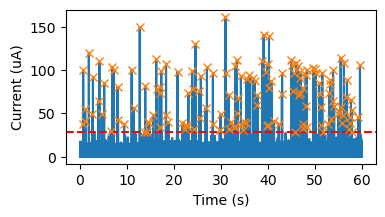

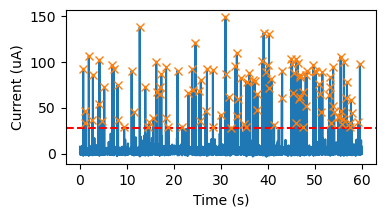

In [206]:
sd_threshold = mean_noise + 12*sd_noise
rec = rec[:len(x_base)]

peaks_DWT, properties_DWT = find_peaks(rec, height=sd_threshold, distance=400, width = 50) # min 5000 data points between each peak, 5000 data points = 0.004s
# don't want to count a peak twice but don't want to miss if 2 peaks are nearby
# want to make distance equal to the average dwell time

plt.plot(x_base, y_base, label='Current vs. Time')
plt.axhline(y=sd_threshold, color='r', linestyle='--', label='Threshold')
plt.plot(x_base[peaks], y_base[peaks], "x", label='Peaks')
plt.xlabel('Time (s)')
plt.ylabel('Current (uA)')
plt.show()

plt.plot(x_base, rec, label='Current vs. Time')
plt.axhline(y=sd_threshold, color='r', linestyle='--', label='Threshold')
plt.plot(x_base[peaks_DWT], rec[peaks_DWT], "x", label='Peaks')
plt.xlabel('Time (s)')
plt.ylabel('Current (uA)')
plt.show()

In [208]:
event_time_DWT, event_data_DWT, smo_DWT = event_isolation(x_base, rec, peaks_DWT, properties_DWT)

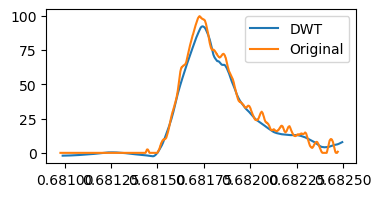

In [241]:
# plotting a single event + DWT (where DWT was performed on the whole signal)
plt.plot(event_time_DWT[0], event_data_DWT[0], label = "DWT")
plt.plot(event_time[0], event_data[0], label = "Original")
plt.legend()
plt.show()

DWT of individual events

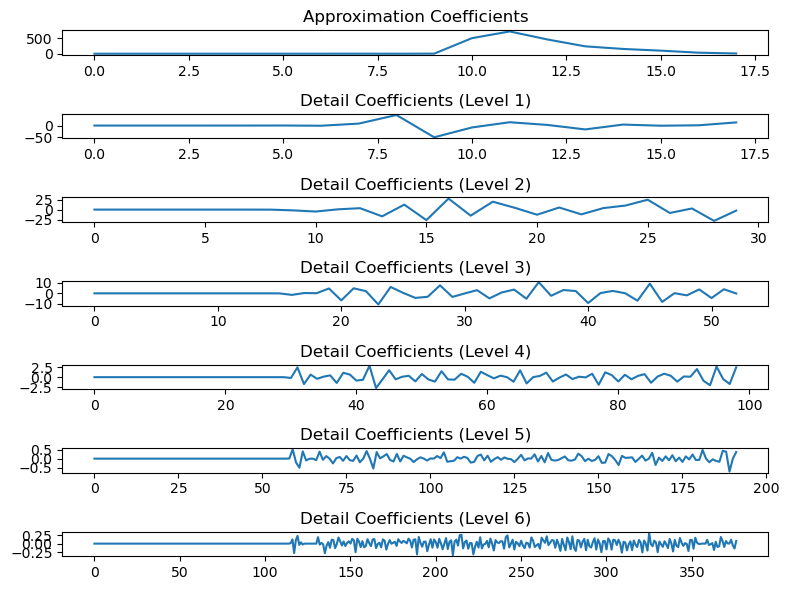

In [ ]:
wavelet = 'db4'  # or another wavelet as 'sym5', 'coif5', etc.
max_level = pywt.dwt_max_level(len(event_data_nores[0]), pywt.Wavelet(wavelet).dec_len)
coeffs = pywt.wavedec(event_data_nores[0], wavelet, level=max_level) # mutlilevel decomposition

features = []
for detail_coeffs in coeffs[1:]:  # Skip the approximation coefficients at index 0
    features.append(np.mean(detail_coeffs))
    features.append(np.var(detail_coeffs))
# Add more feature extraction as needed



plt.figure(figsize=(8, 6))
# Plot the approximation coefficients
plt.subplot(len(coeffs), 1, 1)
plt.plot(coeffs[0])
plt.title('Approximation Coefficients')

# Plot the detail coefficients
for i, detail_coeffs in enumerate(coeffs[1:], start=2):
    plt.subplot(len(coeffs), 1, i)
    plt.plot(detail_coeffs)
    plt.title(f'Detail Coefficients (Level {i-1})')
plt.tight_layout()
plt.savefig("MSci_python_images/wavelet_decomposition.png", dpi=300)
plt.show()

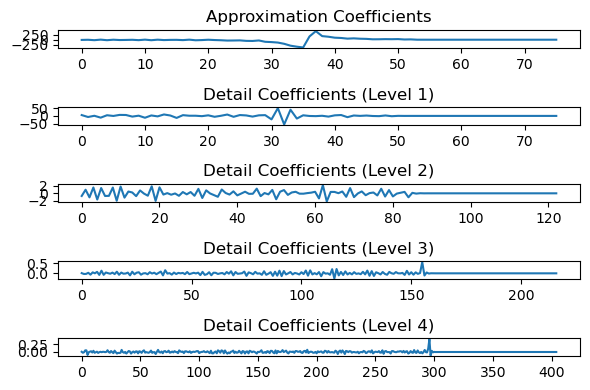

In [ ]:
# event_data_NP_padded
wavelet = 'coif5'  # or another wavelet as 'sym5', 'coif5', etc.
max_level = pywt.dwt_max_level(len(event_data_NP_padded[0]), pywt.Wavelet(wavelet).dec_len)
coeffs = pywt.wavedec(event_data_NP_padded[0], wavelet, level=max_level) # mutlilevel decomposition

features = []
for detail_coeffs in coeffs[1:]:  # Skip the approximation coefficients at index 0
    features.append(np.mean(detail_coeffs))
    features.append(np.var(detail_coeffs))
# Add more feature extraction as needed



plt.figure(figsize=(6, 4))
# Plot the approximation coefficients
plt.subplot(len(coeffs), 1, 1)
plt.plot(coeffs[0])
plt.title('Approximation Coefficients')

# Plot the detail coefficients
for i, detail_coeffs in enumerate(coeffs[1:], start=2):
    plt.subplot(len(coeffs), 1, i)
    plt.plot(detail_coeffs)
    plt.title(f'Detail Coefficients (Level {i-1})')
plt.tight_layout()
plt.show()

/var/folders/br/67qx_45113s31sykxddgpjyw0000gn/T/ipykernel_20006/3906900770.py:26: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


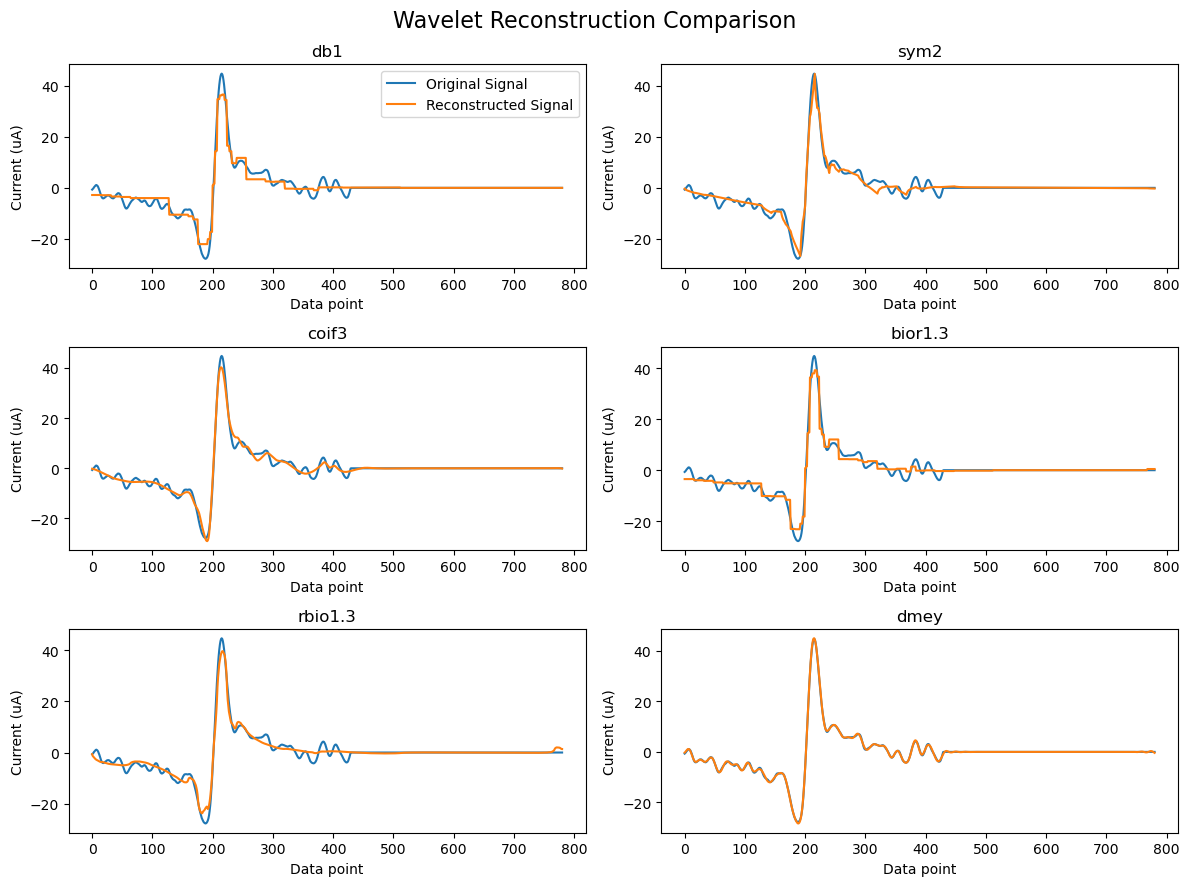

In [579]:

wavelet_families = ['db1', 'sym2', 'coif3', 'bior1.3', 'rbio1.3', 'dmey']
n_rows, n_cols = 3, 2
fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 9))  # Adjust the figsize as needed

for i, wavelet in enumerate(wavelet_families):
    row, col = divmod(i, n_cols)
    reconstructed_signal = lowpassfilter(event_data_NP_padded[0], thresh=0.2, wavelet=wavelet)[0][:len(event_data_NP_padded[0])]
    
    if i == 0:
        axs[row, col].plot(event_data_NP_padded[0], label='Original Signal')
        axs[row, col].plot(reconstructed_signal, label='Reconstructed Signal')
        axs[row, col].legend()
    else:
        axs[row, col].plot(event_data_NP_padded[0])
        axs[row, col].plot(reconstructed_signal)
    
    axs[row, col].set_title(wavelet)
    axs[row, col].set_ylabel('Current (uA)')
    axs[row, col].set_xlabel('Data point')


plt.suptitle('Wavelet Reconstruction Comparison', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.savefig("MSci_python_images/wavelet_reconstruction_6wavelets.png", dpi=300)
plt.tight_layout()
plt.show()


#### DWT for feature extraction and signal classificaiton
- could use a model to choose the best wavelet for the data/each event e.g. initially analyze the signal using a generic wavelet to extract basic features. Use these features to classify the signal type with your trained model, and then apply the appropriate wavelet for further analysis.

Features
- Derivative features
    - max deriv: this will be the part where the trough rapidly ascends to a peak and may be different for NPs of different sizes
    - sum of absolute changes: can be useful for understanding the overall variability in the data (possibly similar to entropy)

- can do time to reach trough and time to decay down from peak 
- looking in the nanopore app, 5nm and 10nm seem separable from dwell time and charge (of conductive peak)

### Preparing data for ML

Expected ratio of 5nm/10nm

In [215]:
len(y_base_10nm_0013)

29990001

In [214]:
tot_len

1425928

In [70]:
all_event_data_5nm = [event_data_5nm_0002, 
                   event_data_5nm_0003,
                   event_data_5nm_0004,
                   event_data_5nm_0005,
                   event_data_5nm_0006,
                   event_data_5nm_0007]

all_event_data_10nm = [event_data_10nm_0002,
                   event_data_10nm_0003,
                   event_data_10nm_0004,
                   event_data_10nm_0005,
                   event_data_10nm_0006,
                   event_data_10nm_0007,
                   event_data_10nm_0008,
                   event_data_10nm_0009,
                   event_data_10nm_0010,
                   event_data_10nm_0011,
                   event_data_10nm_0012,
                   event_data_10nm_0013,
                   event_data_10nm_0014,
                   event_data_10nm_0015,
                   event_data_10nm_0016,
                   event_data_10nm_0017,
                   event_data_10nm_0018,
                   event_data_10nm_0019,
                   event_data_10nm_0020]

no_5nm = 0
no_10nm = 0

for i in all_event_data_5nm:
    no_5nm += len(i)
for i in all_event_data_10nm:
    no_10nm += len(i)
avg_no_5nm = no_5nm/len(all_event_data_5nm)
avg_no_10nm = no_10nm/len(all_event_data_10nm)

print("avg number of events per 5nm run: ", int(avg_no_5nm))
print("avg number of events per 10nm run: ", int(avg_no_10nm))
print("expected ratio of 5nm to 10nm events: ", avg_no_5nm/avg_no_10nm)

avg number of events per 5nm run:  173
avg number of events per 10nm run:  95
expected ratio of 5nm to 10nm events:  1.816022099447514


pickle event data

In [119]:


save_with_pickle('all_event_time_5nm.pkl', all_event_time_5nm)
save_with_pickle('all_event_time_10nm.pkl', all_event_time_10nm)
save_with_pickle('all_event_data_5nm.pkl', all_event_data_5nm)
save_with_pickle('all_event_data_10nm.pkl', all_event_data_10nm)

Getting features

In [72]:
def DWT_and_features(event_time, event_data, mean_noise, sd_threshold, sd_threshold_lower, NP_size):
    
    DWT_rec, all_coeffs = zip(*[lowpassfilter(signal) for signal in event_data])
    DWT_rec, all_coeffs = list(DWT_rec), list(all_coeffs)
    event_time_padded, DWT_rec_padded = pad_event(event_time, DWT_rec, mean_noise)
    features_df, features_list =  find_features_CWT(event_time_padded, DWT_rec_padded, mean_noise, all_coeffs, sd_threshold, sd_threshold_lower)
    if NP_size == 5:
        labels = list(np.zeros(len(features_list)))
    else:
        labels = list(np.ones(len(features_list)))
    
    return DWT_rec, event_time_padded, DWT_rec_padded, features_df, features_list, labels, all_coeffs

In [73]:
def noDWT_and_features(event_time, event_data, mean_noise, sd_threshold, sd_threshold_lower, NP_size):
    # perform DWT to get coefficient array dimensions (so you can still use the same functions)
    DWT_rec, all_coeffs = zip(*[lowpassfilter(signal) for signal in event_data])
    DWT_rec, all_coeffs = list(DWT_rec), list(all_coeffs)
    
    # set all_coeffs to zero
    all_coeffs = [[np.zeros(len(j)) for j in i] for i in all_coeffs]
    

    event_time_padded, event_data_padded = pad_event(event_time, event_data, mean_noise)
    features_df, features_list =  find_features_CWT(event_time_padded, event_data_padded, mean_noise, all_coeffs, sd_threshold, sd_threshold_lower)
    if NP_size == 5:
        labels = list(np.zeros(len(features_list)))
    else:
        labels = list(np.ones(len(features_list)))
    
    return event_time_padded, event_data_padded, features_df, features_list, labels, all_coeffs

In [76]:
DWT_rec_5nm_0002, event_time_padded_5nm_0002, DWT_rec_padded_5nm_0002, features_5nm_0002_df, features_5nm_0002_list, labels_5nm_0002, all_coeffs_5nm_0002 = DWT_and_features(event_time_5nm_0002, event_data_5nm_0002, mean_noise_5nm_0002, sd_threshold_5nm_0002, sd_threshold_lower_5nm_0002, 5)
DWT_rec_5nm_0003, event_time_padded_5nm_0003, DWT_rec_padded_5nm_0003, features_5nm_0003_df, features_5nm_0003_list, labels_5nm_0003, all_coeffs_5nm_0003 = DWT_and_features(event_time_5nm_0003, event_data_5nm_0003, mean_noise_5nm_0003, sd_threshold_5nm_0003, sd_threshold_lower_5nm_0003, 5)
DWT_rec_5nm_0004, event_time_padded_5nm_0004, DWT_rec_padded_5nm_0004, features_5nm_0004_df, features_5nm_0004_list, labels_5nm_0004, all_coeffs_5nm_0004 = DWT_and_features(event_time_5nm_0004, event_data_5nm_0004, mean_noise_5nm_0004, sd_threshold_5nm_0004, sd_threshold_lower_5nm_0004, 5)
DWT_rec_5nm_0005, event_time_padded_5nm_0005, DWT_rec_padded_5nm_0005, features_5nm_0005_df, features_5nm_0005_list, labels_5nm_0005, all_coeffs_5nm_0005 = DWT_and_features(event_time_5nm_0005, event_data_5nm_0005, mean_noise_5nm_0005, sd_threshold_5nm_0005, sd_threshold_lower_5nm_0005, 5)
DWT_rec_5nm_0006, event_time_padded_5nm_0006, DWT_rec_padded_5nm_0006, features_5nm_0006_df, features_5nm_0006_list, labels_5nm_0006, all_coeffs_5nm_0006 = DWT_and_features(event_time_5nm_0006, event_data_5nm_0006, mean_noise_5nm_0006, sd_threshold_5nm_0006, sd_threshold_lower_5nm_0006, 5)
DWT_rec_5nm_0007, event_time_padded_5nm_0007, DWT_rec_padded_5nm_0007, features_5nm_0007_df, features_5nm_0007_list, labels_5nm_0007, all_coeffs_5nm_0007 = DWT_and_features(event_time_5nm_0007, event_data_5nm_0007, mean_noise_5nm_0007, sd_threshold_5nm_0007, sd_threshold_lower_5nm_0007, 5)


In [77]:
# 10nm (~7 seconds to run)
DWT_rec_10nm_0002, event_time_padded_10nm_0002, DWT_rec_padded_10nm_0002, features_10nm_0002_df, features_10nm_0002_list, labels_10nm_0002, all_coeffs_10nm_0002 = DWT_and_features(event_time_10nm_0002, event_data_10nm_0002, mean_noise_10nm_0002, sd_threshold_10nm_0002, sd_threshold_lower_10nm_0002, 10)
DWT_rec_10nm_0003, event_time_padded_10nm_0003, DWT_rec_padded_10nm_0003, features_10nm_0003_df, features_10nm_0003_list, labels_10nm_0003, all_coeffs_10nm_0003 = DWT_and_features(event_time_10nm_0003, event_data_10nm_0003, mean_noise_10nm_0003, sd_threshold_10nm_0003, sd_threshold_lower_10nm_0003, 10)
DWT_rec_10nm_0004, event_time_padded_10nm_0004, DWT_rec_padded_10nm_0004, features_10nm_0004_df, features_10nm_0004_list, labels_10nm_0004, all_coeffs_10nm_0004 = DWT_and_features(event_time_10nm_0004, event_data_10nm_0004, mean_noise_10nm_0004, sd_threshold_10nm_0004, sd_threshold_lower_10nm_0004, 10)
DWT_rec_10nm_0005, event_time_padded_10nm_0005, DWT_rec_padded_10nm_0005, features_10nm_0005_df, features_10nm_0005_list, labels_10nm_0005, all_coeffs_10nm_0005 = DWT_and_features(event_time_10nm_0005, event_data_10nm_0005, mean_noise_10nm_0005, sd_threshold_10nm_0005, sd_threshold_lower_10nm_0005, 10)
DWT_rec_10nm_0006, event_time_padded_10nm_0006, DWT_rec_padded_10nm_0006, features_10nm_0006_df, features_10nm_0006_list, labels_10nm_0006, all_coeffs_10nm_0006 = DWT_and_features(event_time_10nm_0006, event_data_10nm_0006, mean_noise_10nm_0006, sd_threshold_10nm_0006, sd_threshold_lower_10nm_0006, 10)
DWT_rec_10nm_0007, event_time_padded_10nm_0007, DWT_rec_padded_10nm_0007, features_10nm_0007_df, features_10nm_0007_list, labels_10nm_0007, all_coeffs_10nm_0007 = DWT_and_features(event_time_10nm_0007, event_data_10nm_0007, mean_noise_10nm_0007, sd_threshold_10nm_0007, sd_threshold_lower_10nm_0007, 10)
DWT_rec_10nm_0008, event_time_padded_10nm_0008, DWT_rec_padded_10nm_0008, features_10nm_0008_df, features_10nm_0008_list, labels_10nm_0008, all_coeffs_10nm_0008 = DWT_and_features(event_time_10nm_0008, event_data_10nm_0008, mean_noise_10nm_0008, sd_threshold_10nm_0008, sd_threshold_lower_10nm_0008, 10)
DWT_rec_10nm_0009, event_time_padded_10nm_0009, DWT_rec_padded_10nm_0009, features_10nm_0009_df, features_10nm_0009_list, labels_10nm_0009, all_coeffs_10nm_0009 = DWT_and_features(event_time_10nm_0009, event_data_10nm_0009, mean_noise_10nm_0009, sd_threshold_10nm_0009, sd_threshold_lower_10nm_0009, 10)
DWT_rec_10nm_0010, event_time_padded_10nm_0010, DWT_rec_padded_10nm_0010, features_10nm_0010_df, features_10nm_0010_list, labels_10nm_0010, all_coeffs_10nm_0010 = DWT_and_features(event_time_10nm_0010, event_data_10nm_0010, mean_noise_10nm_0010, sd_threshold_10nm_0010, sd_threshold_lower_10nm_0010, 10)
DWT_rec_10nm_0011, event_time_padded_10nm_0011, DWT_rec_padded_10nm_0011, features_10nm_0011_df, features_10nm_0011_list, labels_10nm_0011, all_coeffs_10nm_0011 = DWT_and_features(event_time_10nm_0011, event_data_10nm_0011, mean_noise_10nm_0011, sd_threshold_10nm_0011, sd_threshold_lower_10nm_0011, 10)
DWT_rec_10nm_0012, event_time_padded_10nm_0012, DWT_rec_padded_10nm_0012, features_10nm_0012_df, features_10nm_0012_list, labels_10nm_0012, all_coeffs_10nm_0012 = DWT_and_features(event_time_10nm_0012, event_data_10nm_0012, mean_noise_10nm_0012, sd_threshold_10nm_0012, sd_threshold_lower_10nm_0012, 10)
DWT_rec_10nm_0013, event_time_padded_10nm_0013, DWT_rec_padded_10nm_0013, features_10nm_0013_df, features_10nm_0013_list, labels_10nm_0013, all_coeffs_10nm_0013 = DWT_and_features(event_time_10nm_0013, event_data_10nm_0013, mean_noise_10nm_0013, sd_threshold_10nm_0013, sd_threshold_lower_10nm_0013, 10)
DWT_rec_10nm_0014, event_time_padded_10nm_0014, DWT_rec_padded_10nm_0014, features_10nm_0014_df, features_10nm_0014_list, labels_10nm_0014, all_coeffs_10nm_0014 = DWT_and_features(event_time_10nm_0014, event_data_10nm_0014, mean_noise_10nm_0014, sd_threshold_10nm_0014, sd_threshold_lower_10nm_0014, 10)
DWT_rec_10nm_0015, event_time_padded_10nm_0015, DWT_rec_padded_10nm_0015, features_10nm_0015_df, features_10nm_0015_list, labels_10nm_0015, all_coeffs_10nm_0015 = DWT_and_features(event_time_10nm_0015, event_data_10nm_0015, mean_noise_10nm_0015, sd_threshold_10nm_0015, sd_threshold_lower_10nm_0015, 10)
DWT_rec_10nm_0016, event_time_padded_10nm_0016, DWT_rec_padded_10nm_0016, features_10nm_0016_df, features_10nm_0016_list, labels_10nm_0016, all_coeffs_10nm_0016 = DWT_and_features(event_time_10nm_0016, event_data_10nm_0016, mean_noise_10nm_0016, sd_threshold_10nm_0016, sd_threshold_lower_10nm_0016, 10)
DWT_rec_10nm_0017, event_time_padded_10nm_0017, DWT_rec_padded_10nm_0017, features_10nm_0017_df, features_10nm_0017_list, labels_10nm_0017, all_coeffs_10nm_0017 = DWT_and_features(event_time_10nm_0017, event_data_10nm_0017, mean_noise_10nm_0017, sd_threshold_10nm_0017, sd_threshold_lower_10nm_0017, 10)
DWT_rec_10nm_0018, event_time_padded_10nm_0018, DWT_rec_padded_10nm_0018, features_10nm_0018_df, features_10nm_0018_list, labels_10nm_0018, all_coeffs_10nm_0018 = DWT_and_features(event_time_10nm_0018, event_data_10nm_0018, mean_noise_10nm_0018, sd_threshold_10nm_0018, sd_threshold_lower_10nm_0018, 10)
DWT_rec_10nm_0019, event_time_padded_10nm_0019, DWT_rec_padded_10nm_0019, features_10nm_0019_df, features_10nm_0019_list, labels_10nm_0019, all_coeffs_10nm_0019 = DWT_and_features(event_time_10nm_0019, event_data_10nm_0019, mean_noise_10nm_0019, sd_threshold_10nm_0019, sd_threshold_lower_10nm_0019, 10)
DWT_rec_10nm_0020, event_time_padded_10nm_0020, DWT_rec_padded_10nm_0020, features_10nm_0020_df, features_10nm_0020_list, labels_10nm_0020, all_coeffs_10nm_0020 = DWT_and_features(event_time_10nm_0020, event_data_10nm_0020, mean_noise_10nm_0020, sd_threshold_10nm_0020, sd_threshold_lower_10nm_0020, 10)

no DWT

In [ ]:
noDWT_event_time_padded_5nm_0002, noDWT_event_data_padded_5nm_0002, noDWT_features_5nm_0002_df, noDWT_features_5nm_0002_list, noDWT_labels_5nm_0002, noDWT_all_coeffs_5nm_0002 = noDWT_and_features(event_time_5nm_0002, event_data_5nm_0002, mean_noise_5nm_0002, sd_threshold_5nm_0002, sd_threshold_lower_5nm_0002, 5)
noDWT_event_time_padded_5nm_0003, noDWT_event_data_padded_5nm_0003, noDWT_features_5nm_0003_df, noDWT_features_5nm_0003_list, noDWT_labels_5nm_0003, noDWT_all_coeffs_5nm_0003 = noDWT_and_features(event_time_5nm_0003, event_data_5nm_0003, mean_noise_5nm_0003, sd_threshold_5nm_0003, sd_threshold_lower_5nm_0003, 5)
noDWT_event_time_padded_5nm_0004, noDWT_event_data_padded_5nm_0004, noDWT_features_5nm_0004_df, noDWT_features_5nm_0004_list, noDWT_labels_5nm_0004, noDWT_all_coeffs_5nm_0004 = noDWT_and_features(event_time_5nm_0004, event_data_5nm_0004, mean_noise_5nm_0004, sd_threshold_5nm_0004, sd_threshold_lower_5nm_0004, 5)
noDWT_event_time_padded_5nm_0005, noDWT_event_data_padded_5nm_0005, noDWT_features_5nm_0005_df, noDWT_features_5nm_0005_list, noDWT_labels_5nm_0005, noDWT_all_coeffs_5nm_0005 = noDWT_and_features(event_time_5nm_0005, event_data_5nm_0005, mean_noise_5nm_0005, sd_threshold_5nm_0005, sd_threshold_lower_5nm_0005, 5)
noDWT_event_time_padded_5nm_0006, noDWT_event_data_padded_5nm_0006, noDWT_features_5nm_0006_df, noDWT_features_5nm_0006_list, noDWT_labels_5nm_0006, noDWT_all_coeffs_5nm_0006 = noDWT_and_features(event_time_5nm_0006, event_data_5nm_0006, mean_noise_5nm_0006, sd_threshold_5nm_0006, sd_threshold_lower_5nm_0006, 5)
noDWT_event_time_padded_5nm_0007, noDWT_event_data_padded_5nm_0007, noDWT_features_5nm_0007_df, noDWT_features_5nm_0007_list, noDWT_labels_5nm_0007, noDWT_all_coeffs_5nm_0007 = noDWT_and_features(event_time_5nm_0007, event_data_5nm_0007, mean_noise_5nm_0007, sd_threshold_5nm_0007, sd_threshold_lower_5nm_0007, 5)

noDWT_event_time_padded_10nm_0002, noDWT_event_data_padded_10nm_0002, noDWT_features_10nm_0002_df, noDWT_features_10nm_0002_list, noDWT_labels_10nm_0002, noDWT_all_coeffs_10nm_0002 = noDWT_and_features(event_time_10nm_0002, event_data_10nm_0002, mean_noise_10nm_0002, sd_threshold_10nm_0002, sd_threshold_lower_10nm_0002, 10)
noDWT_event_time_padded_10nm_0003, noDWT_event_data_padded_10nm_0003, noDWT_features_10nm_0003_df, noDWT_features_10nm_0003_list, noDWT_labels_10nm_0003, noDWT_all_coeffs_10nm_0003 = noDWT_and_features(event_time_10nm_0003, event_data_10nm_0003, mean_noise_10nm_0003, sd_threshold_10nm_0003, sd_threshold_lower_10nm_0003, 10)
noDWT_event_time_padded_10nm_0004, noDWT_event_data_padded_10nm_0004, noDWT_features_10nm_0004_df, noDWT_features_10nm_0004_list, noDWT_labels_10nm_0004, noDWT_all_coeffs_10nm_0004 = noDWT_and_features(event_time_10nm_0004, event_data_10nm_0004, mean_noise_10nm_0004, sd_threshold_10nm_0004, sd_threshold_lower_10nm_0004, 10)
noDWT_event_time_padded_10nm_0005, noDWT_event_data_padded_10nm_0005, noDWT_features_10nm_0005_df, noDWT_features_10nm_0005_list, noDWT_labels_10nm_0005, noDWT_all_coeffs_10nm_0005 = noDWT_and_features(event_time_10nm_0005, event_data_10nm_0005, mean_noise_10nm_0005, sd_threshold_10nm_0005, sd_threshold_lower_10nm_0005, 10)
noDWT_event_time_padded_10nm_0006, noDWT_event_data_padded_10nm_0006, noDWT_features_10nm_0006_df, noDWT_features_10nm_0006_list, noDWT_labels_10nm_0006, noDWT_all_coeffs_10nm_0006 = noDWT_and_features(event_time_10nm_0006, event_data_10nm_0006, mean_noise_10nm_0006, sd_threshold_10nm_0006, sd_threshold_lower_10nm_0006, 10)
noDWT_event_time_padded_10nm_0007, noDWT_event_data_padded_10nm_0007, noDWT_features_10nm_0007_df, noDWT_features_10nm_0007_list, noDWT_labels_10nm_0007, noDWT_all_coeffs_10nm_0007 = noDWT_and_features(event_time_10nm_0007, event_data_10nm_0007, mean_noise_10nm_0007, sd_threshold_10nm_0007, sd_threshold_lower_10nm_0007, 10)
noDWT_event_time_padded_10nm_0008, noDWT_event_data_padded_10nm_0008, noDWT_features_10nm_0008_df, noDWT_features_10nm_0008_list, noDWT_labels_10nm_0008, noDWT_all_coeffs_10nm_0008 = noDWT_and_features(event_time_10nm_0008, event_data_10nm_0008, mean_noise_10nm_0008, sd_threshold_10nm_0008, sd_threshold_lower_10nm_0008, 10)
noDWT_event_time_padded_10nm_0009, noDWT_event_data_padded_10nm_0009, noDWT_features_10nm_0009_df, noDWT_features_10nm_0009_list, noDWT_labels_10nm_0009, noDWT_all_coeffs_10nm_0009 = noDWT_and_features(event_time_10nm_0009, event_data_10nm_0009, mean_noise_10nm_0009, sd_threshold_10nm_0009, sd_threshold_lower_10nm_0009, 10)
noDWT_event_time_padded_10nm_0010, noDWT_event_data_padded_10nm_0010, noDWT_features_10nm_0010_df, noDWT_features_10nm_0010_list, noDWT_labels_10nm_0010, noDWT_all_coeffs_10nm_0010 = noDWT_and_features(event_time_10nm_0010, event_data_10nm_0010, mean_noise_10nm_0010, sd_threshold_10nm_0010, sd_threshold_lower_10nm_0010, 10)
noDWT_event_time_padded_10nm_0011, noDWT_event_data_padded_10nm_0011, noDWT_features_10nm_0011_df, noDWT_features_10nm_0011_list, noDWT_labels_10nm_0011, noDWT_all_coeffs_10nm_0011 = noDWT_and_features(event_time_10nm_0011, event_data_10nm_0011, mean_noise_10nm_0011, sd_threshold_10nm_0011, sd_threshold_lower_10nm_0011, 10)
noDWT_event_time_padded_10nm_0012, noDWT_event_data_padded_10nm_0012, noDWT_features_10nm_0012_df, noDWT_features_10nm_0012_list, noDWT_labels_10nm_0012, noDWT_all_coeffs_10nm_0012 = noDWT_and_features(event_time_10nm_0012, event_data_10nm_0012, mean_noise_10nm_0012, sd_threshold_10nm_0012, sd_threshold_lower_10nm_0012, 10)
noDWT_event_time_padded_10nm_0013, noDWT_event_data_padded_10nm_0013, noDWT_features_10nm_0013_df, noDWT_features_10nm_0013_list, noDWT_labels_10nm_0013, noDWT_all_coeffs_10nm_0013 = noDWT_and_features(event_time_10nm_0013, event_data_10nm_0013, mean_noise_10nm_0013, sd_threshold_10nm_0013, sd_threshold_lower_10nm_0013, 10)
noDWT_event_time_padded_10nm_0014, noDWT_event_data_padded_10nm_0014, noDWT_features_10nm_0014_df, noDWT_features_10nm_0014_list, noDWT_labels_10nm_0014, noDWT_all_coeffs_10nm_0014 = noDWT_and_features(event_time_10nm_0014, event_data_10nm_0014, mean_noise_10nm_0014, sd_threshold_10nm_0014, sd_threshold_lower_10nm_0014, 10)
noDWT_event_time_padded_10nm_0015, noDWT_event_data_padded_10nm_0015, noDWT_features_10nm_0015_df, noDWT_features_10nm_0015_list, noDWT_labels_10nm_0015, noDWT_all_coeffs_10nm_0015 = noDWT_and_features(event_time_10nm_0015, event_data_10nm_0015, mean_noise_10nm_0015, sd_threshold_10nm_0015, sd_threshold_lower_10nm_0015, 10)
noDWT_event_time_padded_10nm_0016, noDWT_event_data_padded_10nm_0016, noDWT_features_10nm_0016_df, noDWT_features_10nm_0016_list, noDWT_labels_10nm_0016, noDWT_all_coeffs_10nm_0016 = noDWT_and_features(event_time_10nm_0016, event_data_10nm_0016, mean_noise_10nm_0016, sd_threshold_10nm_0016, sd_threshold_lower_10nm_0016, 10)
noDWT_event_time_padded_10nm_0017, noDWT_event_data_padded_10nm_0017, noDWT_features_10nm_0017_df, noDWT_features_10nm_0017_list, noDWT_labels_10nm_0017, noDWT_all_coeffs_10nm_0017 = noDWT_and_features(event_time_10nm_0017, event_data_10nm_0017, mean_noise_10nm_0017, sd_threshold_10nm_0017, sd_threshold_lower_10nm_0017, 10)
noDWT_event_time_padded_10nm_0018, noDWT_event_data_padded_10nm_0018, noDWT_features_10nm_0018_df, noDWT_features_10nm_0018_list, noDWT_labels_10nm_0018, noDWT_all_coeffs_10nm_0018 = noDWT_and_features(event_time_10nm_0018, event_data_10nm_0018, mean_noise_10nm_0018, sd_threshold_10nm_0018, sd_threshold_lower_10nm_0018, 10)
noDWT_event_time_padded_10nm_0019, noDWT_event_data_padded_10nm_0019, noDWT_features_10nm_0019_df, noDWT_features_10nm_0019_list, noDWT_labels_10nm_0019, noDWT_all_coeffs_10nm_0019 = noDWT_and_features(event_time_10nm_0019, event_data_10nm_0019, mean_noise_10nm_0019, sd_threshold_10nm_0019, sd_threshold_lower_10nm_0019, 10)
noDWT_event_time_padded_10nm_0020, noDWT_event_data_padded_10nm_0020, noDWT_features_10nm_0020_df, noDWT_features_10nm_0020_list, noDWT_labels_10nm_0020, noDWT_all_coeffs_10nm_0020 = noDWT_and_features(event_time_10nm_0020, event_data_10nm_0020, mean_noise_10nm_0020, sd_threshold_10nm_0020, sd_threshold_lower_10nm_0020, 10)

Function to apply all types of wavelets to data

In [81]:
event_times_all_wavelets = [event_time_5nm_0002, 
                   event_time_5nm_0003,
                   event_time_5nm_0004,
                   event_time_5nm_0005,
                   event_time_5nm_0006,
                   event_time_5nm_0007, 
                   event_time_10nm_0002,
                   event_time_10nm_0003,
                   event_time_10nm_0004,
                   event_time_10nm_0005,
                   event_time_10nm_0006,
                   event_time_10nm_0007,
                   event_time_10nm_0008,
                   event_time_10nm_0009,
                   event_time_10nm_0010,
                   event_time_10nm_0011,
                   event_time_10nm_0012,
                   event_time_10nm_0013,
                   event_time_10nm_0014,
                   event_time_10nm_0015,
                   event_time_10nm_0016,
                   event_time_10nm_0017,
                   event_time_10nm_0018,
                   event_time_10nm_0019,
                   event_time_10nm_0020]

event_datas_all_wavelets = [event_data_5nm_0002, 
                   event_data_5nm_0003,
                   event_data_5nm_0004,
                   event_data_5nm_0005,
                   event_data_5nm_0006,
                   event_data_5nm_0007,
                   event_data_10nm_0002,
                   event_data_10nm_0003,
                   event_data_10nm_0004,
                   event_data_10nm_0005,
                   event_data_10nm_0006,
                   event_data_10nm_0007,
                   event_data_10nm_0008,
                   event_data_10nm_0009,
                   event_data_10nm_0010,
                   event_data_10nm_0011,
                   event_data_10nm_0012,
                   event_data_10nm_0013,
                   event_data_10nm_0014,
                   event_data_10nm_0015,
                   event_data_10nm_0016,
                   event_data_10nm_0017,
                   event_data_10nm_0018,
                   event_data_10nm_0019,
                   event_data_10nm_0020]


mean_noises_all_wavelets = [mean_noise_5nm_0002, 
    mean_noise_5nm_0003,
    mean_noise_5nm_0004,
    mean_noise_5nm_0005,
    mean_noise_5nm_0006,
    mean_noise_5nm_0007,
    mean_noise_10nm_0002,
    mean_noise_10nm_0003,
    mean_noise_10nm_0004,
    mean_noise_10nm_0005,
    mean_noise_10nm_0006,
    mean_noise_10nm_0007,
    mean_noise_10nm_0008,
    mean_noise_10nm_0009,
    mean_noise_10nm_0010,
    mean_noise_10nm_0011,
    mean_noise_10nm_0012,
    mean_noise_10nm_0013,
    mean_noise_10nm_0014,
    mean_noise_10nm_0015,
    mean_noise_10nm_0016,
    mean_noise_10nm_0017,
    mean_noise_10nm_0018,
    mean_noise_10nm_0019,
    mean_noise_10nm_0020]

sd_thresholds_all_wavelets = [sd_threshold_5nm_0002, 
    sd_threshold_5nm_0003,
    sd_threshold_5nm_0004,
    sd_threshold_5nm_0005,
    sd_threshold_5nm_0006,
    sd_threshold_5nm_0007,
    sd_threshold_10nm_0002,
    sd_threshold_10nm_0003,
    sd_threshold_10nm_0004,
    sd_threshold_10nm_0005,
    sd_threshold_10nm_0006,
    sd_threshold_10nm_0007,
    sd_threshold_10nm_0008,
    sd_threshold_10nm_0009,
    sd_threshold_10nm_0010,
    sd_threshold_10nm_0011,
    sd_threshold_10nm_0012,
    sd_threshold_10nm_0013,
    sd_threshold_10nm_0014,
    sd_threshold_10nm_0015,
    sd_threshold_10nm_0016,
    sd_threshold_10nm_0017,
    sd_threshold_10nm_0018,
    sd_threshold_10nm_0019,
    sd_threshold_10nm_0020]


sd_thresholds_lower_all_wavelets = [sd_threshold_lower_5nm_0002, 
    sd_threshold_lower_5nm_0003,
    sd_threshold_lower_5nm_0004,
    sd_threshold_lower_5nm_0005,
    sd_threshold_lower_5nm_0006,
    sd_threshold_lower_5nm_0007,
    sd_threshold_lower_10nm_0002,
    sd_threshold_lower_10nm_0003,
    sd_threshold_lower_10nm_0004,
    sd_threshold_lower_10nm_0005,
    sd_threshold_lower_10nm_0006,
    sd_threshold_lower_10nm_0007,
    sd_threshold_lower_10nm_0008,
    sd_threshold_lower_10nm_0009,
    sd_threshold_lower_10nm_0010,
    sd_threshold_lower_10nm_0011,
    sd_threshold_lower_10nm_0012,
    sd_threshold_lower_10nm_0013,
    sd_threshold_lower_10nm_0014,
    sd_threshold_lower_10nm_0015,
    sd_threshold_lower_10nm_0016,
    sd_threshold_lower_10nm_0017,
    sd_threshold_lower_10nm_0018,
    sd_threshold_lower_10nm_0019,
    sd_threshold_lower_10nm_0020]

NP_sizes_all_wavelets = [5,5,5,5,5,5,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10]



In [84]:
save_with_pickle('event_times_all_wavelets.pkl', event_times_all_wavelets)
save_with_pickle('event_datas_all_wavelets.pkl', event_datas_all_wavelets)
save_with_pickle('mean_noises_all_wavelets.pkl', mean_noises_all_wavelets)
save_with_pickle('sd_thresholds_all_wavelets.pkl', sd_thresholds_all_wavelets)
save_with_pickle('sd_thresholds_lower_all_wavelets.pkl', sd_thresholds_lower_all_wavelets)

In [85]:
len(event_times_all_wavelets)

25

In [109]:

all_features_list = [features_5nm_0002_list,
                     features_5nm_0003_list,
                     features_5nm_0004_list,
                     features_5nm_0005_list,
                     features_5nm_0006_list,
                     features_5nm_0007_list,
                     features_10nm_0002_list,
                     features_10nm_0003_list,
                     features_10nm_0004_list,
                     features_10nm_0005_list,
                     features_10nm_0006_list,
                     features_10nm_0007_list,
                     features_10nm_0008_list,
                     features_10nm_0009_list,
                     features_10nm_0010_list,
                     features_10nm_0011_list,
                     features_10nm_0012_list,
                     features_10nm_0013_list,
                     features_10nm_0014_list,
                     features_10nm_0015_list,
                     features_10nm_0016_list,
                     features_10nm_0017_list,
                     features_10nm_0018_list]


all_labels_list = [labels_5nm_0002, 
                   labels_5nm_0003,
                   labels_5nm_0004,
                   labels_5nm_0005,
                   labels_5nm_0006,
                   labels_5nm_0007,
                   labels_10nm_0002,
                   labels_10nm_0003,
                   labels_10nm_0004,
                   labels_10nm_0005,
                   labels_10nm_0006,
                   labels_10nm_0007,
                   labels_10nm_0008,
                   labels_10nm_0009,
                   labels_10nm_0010,
                   labels_10nm_0011,
                   labels_10nm_0012,
                   labels_10nm_0013,
                   labels_10nm_0014,
                   labels_10nm_0015,
                   labels_10nm_0016,
                   labels_10nm_0017,
                   labels_10nm_0018]

X_no1920 = []
for feature in all_features_list:
    X_no1920 += feature
y_no1920 = []
for labels in all_labels_list:
    y_no1920 += labels
    
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

#feature scaling: standard scaling = Z-score normalization
X_no1920 = np.array(X_no1920)  # Convert X to a NumPy array for compatibility with Scikit-learn
y_no1920 = np.array(y_no1920)  # Convert y to a NumPy array if it's not already

# Initialize the StandardScaler
# may not be good if you have outliers
#scaler = StandardScaler()
scaler = RobustScaler()

# Fit the scaler to your data and then transform it
X_no1920_scaled = scaler.fit_transform(X_no1920)


In [95]:
X_scaled

array([[-0.0309,  0.2484,  0.562 , ..., -0.4777, -0.3772, -1.5   ],
       [-0.361 ,  0.4032,  0.4733, ...,  0.2861, -0.428 ,  0.    ],
       [-0.4781,  0.6226,  1.1614, ...,  0.4939, -0.4546,  0.5   ],
       ...,
       [-0.3032,  1.2154, 15.8851, ...,  0.8908, -0.7352, -0.75  ],
       [-0.333 ,  1.3552, 65.4249, ..., -5.7302, -0.5882,  0.    ],
       [ 0.2266,  1.2503, 26.6839, ..., -4.1014, -0.4911, -0.5   ]])

In [111]:
# Pickle features and labels
# check which labels are included
save_with_pickle('data_X_features_no1920.pkl', X_no1920)
save_with_pickle('data_y_labels_no1920.pkl', y_no1920)

In [96]:
all_features_list = [features_5nm_0002_list,
                     features_5nm_0003_list,
                     features_5nm_0004_list,
                     features_5nm_0005_list,
                     features_5nm_0006_list,
                     features_5nm_0007_list,
                     features_10nm_0002_list,
                     features_10nm_0003_list,
                     features_10nm_0004_list,
                     features_10nm_0005_list,
                     features_10nm_0006_list,
                     features_10nm_0007_list,
                     features_10nm_0008_list,
                     features_10nm_0009_list,
                     features_10nm_0010_list,
                     features_10nm_0011_list,
                     features_10nm_0012_list,
                     features_10nm_0013_list,
                     features_10nm_0014_list,
                     features_10nm_0015_list,
                     features_10nm_0016_list,
                     features_10nm_0017_list,
                     features_10nm_0018_list,
                     features_10nm_0019_list,
                     features_10nm_0020_list]

# actually all the labels
all_labels_list_all = [labels_5nm_0002, 
                   labels_5nm_0003,
                   labels_5nm_0004,
                   labels_5nm_0005,
                   labels_5nm_0006,
                   labels_5nm_0007,
                   labels_10nm_0002,
                   labels_10nm_0003,
                   labels_10nm_0004,
                   labels_10nm_0005,
                   labels_10nm_0006,
                   labels_10nm_0007,
                   labels_10nm_0008,
                   labels_10nm_0009,
                   labels_10nm_0010,
                   labels_10nm_0011,
                   labels_10nm_0012,
                   labels_10nm_0013,
                   labels_10nm_0014,
                   labels_10nm_0015,
                   labels_10nm_0016,
                   labels_10nm_0017,
                   labels_10nm_0018,
                   labels_10nm_0019,
                   labels_10nm_0020]


X_all = []
for feature in all_features_list:
    X_all += feature



X_all = np.array(X_all)

#scaler = StandardScaler()
scaler = RobustScaler()
X_all_scaled = scaler.fit_transform(X_all)


y_all_labels = []
for labels in all_labels_list_all:
    y_all_labels += labels
y_all_labels = np.array(y_all_labels)

no DWT

In [ ]:
no_DWT_all_features_list = [noDWT_features_5nm_0002_list,
                     noDWT_features_5nm_0003_list,
                     noDWT_features_5nm_0004_list,
                     noDWT_features_5nm_0005_list,
                     noDWT_features_10nm_0002_list,
                     noDWT_features_10nm_0003_list,
                     noDWT_features_10nm_0004_list,
                     noDWT_features_10nm_0005_list,
                     noDWT_features_10nm_0006_list,
                     noDWT_features_10nm_0007_list,
                     noDWT_features_10nm_0008_list,
                     noDWT_features_10nm_0009_list,
                     noDWT_features_10nm_0011_list,
                     noDWT_features_10nm_0012_list,
                     noDWT_features_10nm_0013_list,
                     noDWT_features_10nm_0015_list,
                     noDWT_features_10nm_0016_list,
                     noDWT_features_10nm_0017_list,
                     noDWT_features_10nm_0018_list,
                     noDWT_features_10nm_0019_list,
                     noDWT_features_10nm_0020_list]

no_DWT_features_extra_test = [noDWT_features_5nm_0006_list,
                       noDWT_features_5nm_0007_list,
                       noDWT_features_10nm_0010_list,
                       noDWT_features_10nm_0014_list]


no_DWT_all_labels_list = [noDWT_labels_5nm_0002, 
                   noDWT_labels_5nm_0003,
                   noDWT_labels_5nm_0004,
                   noDWT_labels_5nm_0005,
                   noDWT_labels_10nm_0002,
                   noDWT_labels_10nm_0003,
                   noDWT_labels_10nm_0004,
                   noDWT_labels_10nm_0005,
                   noDWT_labels_10nm_0006,
                   noDWT_labels_10nm_0007,
                   noDWT_labels_10nm_0008,
                   noDWT_labels_10nm_0009,
                   noDWT_labels_10nm_0011,
                   noDWT_labels_10nm_0012,
                   noDWT_labels_10nm_0013,
                   noDWT_labels_10nm_0015,
                   noDWT_labels_10nm_0016,
                   noDWT_labels_10nm_0017,
                   noDWT_labels_10nm_0018,
                   noDWT_labels_10nm_0019,
                   noDWT_labels_10nm_0020]

no_DWT_labels_extra_test = [noDWT_labels_5nm_0006,
                     noDWT_labels_5nm_0007,
                     noDWT_labels_10nm_0010, 
                     noDWT_labels_10nm_0014]

X_noDWT = []
for feature in no_DWT_all_features_list:
    X_noDWT += feature
y_noDWT = []
for labels in no_DWT_all_labels_list:
    y_noDWT += labels

X_noDWT = np.array(X_noDWT)  
y_noDWT = np.array(y_noDWT)  

scaler = RobustScaler()

X_noDWT_scaled = scaler.fit_transform(X_noDWT)

In [171]:
no_DWT_no1920_labels_list = [noDWT_labels_5nm_0002, 
                   noDWT_labels_5nm_0003,
                   noDWT_labels_5nm_0004,
                   noDWT_labels_5nm_0005,
                   noDWT_labels_5nm_0006,
                   noDWT_labels_5nm_0007,
                   noDWT_labels_10nm_0002,
                   noDWT_labels_10nm_0003,
                   noDWT_labels_10nm_0004,
                   noDWT_labels_10nm_0005,
                   noDWT_labels_10nm_0006,
                   noDWT_labels_10nm_0007,
                   noDWT_labels_10nm_0008,
                   noDWT_labels_10nm_0009,
                   noDWT_labels_10nm_0010,
                   noDWT_labels_10nm_0011,
                   noDWT_labels_10nm_0012,
                   noDWT_labels_10nm_0013,
                   noDWT_labels_10nm_0014,
                   noDWT_labels_10nm_0015,
                   noDWT_labels_10nm_0016,
                   noDWT_labels_10nm_0017,
                   noDWT_labels_10nm_0018]

no_DWT_all_labels_list = [noDWT_labels_5nm_0002, 
                   noDWT_labels_5nm_0003,
                   noDWT_labels_5nm_0004,
                   noDWT_labels_5nm_0005,
                   noDWT_labels_5nm_0006,
                   noDWT_labels_5nm_0007,
                   noDWT_labels_10nm_0002,
                   noDWT_labels_10nm_0003,
                   noDWT_labels_10nm_0004,
                   noDWT_labels_10nm_0005,
                   noDWT_labels_10nm_0006,
                   noDWT_labels_10nm_0007,
                   noDWT_labels_10nm_0008,
                   noDWT_labels_10nm_0009,
                   noDWT_labels_10nm_0010,
                   noDWT_labels_10nm_0011,
                   noDWT_labels_10nm_0012,
                   noDWT_labels_10nm_0013,
                   noDWT_labels_10nm_0014,
                   noDWT_labels_10nm_0015,
                   noDWT_labels_10nm_0016,
                   noDWT_labels_10nm_0017,
                   noDWT_labels_10nm_0018,
                   noDWT_labels_10nm_0019,
                   noDWT_labels_10nm_0020]



y_no_DWT_all = []
for labels in no_DWT_all_labels_list:
    y_no_DWT_all += labels

y_no_DWT_no1920 = []
for labels in no_DWT_no1920_labels_list:
    y_no_DWT_no1920 += labels

In [172]:
save_with_pickle('y_no_DWT_all.pkl', y_no_DWT_all)
save_with_pickle('y_no_DWT_no1920.pkl', y_no_DWT_no1920)